# IMEDIA Informe Final

## 1. Introducción

### 1.1 Contexto del dominio

El proyecto se sitúa en el dominio de **análisis de sentimientos en redes sociales**, específicamente en comentarios de Reddit. Plataformas como Reddit concentran debates abiertos sobre noticias, productos y temas sensibles; entender el tono de estas conversaciones es clave para equipos de **marketing, reputación de marca, experiencia de usuario y análisis de comunidades online**.

### 1.2 Relevancia del problema

Contar con una clasificación automática de sentimiento permite:

- Monitorizar de forma temprana crisis de reputación en productos o marcas.
- Priorizar moderación de comentarios especialmente negativos o tóxicos.
- Extraer *insights* de satisfacción/insatisfacción de usuarios sin leer manualmente miles de comentarios.
- Generar señales agregadas para cuadros de mando o modelos aguas abajo (churn, NPS, etc.).

En este contexto, disponer de un **modelo de sentimiento reproducible, versionado y desplegado como servicio** aporta valor tanto técnico (MLOps) como de negocio.

### 1.3 Alcance del proyecto

El alcance cubre de forma completa la cadena:

1. Ingesta y preparación de datos de comentarios de Reddit (`data/raw`, `data/bronze`, `data/interim`).
2. Construcción de una etiqueta binaria de sentimiento a partir del *score* de Reddit.
3. Análisis exploratorio y *data wrangling* para producir los splits procesados en `data/processed/`.
4. Entrenamiento y comparación de **tres familias de modelos**:
   - Dos modelos BERT preentrenados de HuggingFace (solo inferencia).
   - Un modelo clásico MLP sobre embeddings de SentenceTransformer, con HPO.
5. Orquestación del entrenamiento con **Prefect** y trazabilidad con **MLflow/Databricks**.
6. Registro del mejor modelo en el **Model Registry de Unity Catalog**.
7. Exposición de un servicio de inferencia con **FastAPI** y una interfaz de prueba con **Streamlit**, ambos contenerizados con Docker.
8. Despliegue en la nube vía **HuggingFace Spaces** para el backend, consumido por la UI.

Fuera de alcance quedan:

- Moderación de contenido (detección de *hate speech*, ofensivo, etc.).
- Análisis multi-clase detallado (por ejemplo, emociones básicas).
- Retraining automático en producción y *online learning*.

### 1.4 Resumen del dataset

- **Fuente**: comentarios de Reddit descargados y almacenados en `data/raw/reddit/comments_raw.parquet`, posteriormente refinados a través de las capas `bronze`, `interim` y `processed`.
- **Tamaño**:
  - `sentiment_train.parquet`: ~3.2k comentarios.
  - `sentiment_val.parquet`: ~700 comentarios.
  - `sentiment_test.parquet`: ~700 comentarios.
- **Naturaleza de las variables principales**:
  - `clean_text` (texto): comentario normalizado (minúsculas, limpieza de ruido, etc.).
  - `score`, `score_clipped` (numéricas): puntuación de Reddit, winsorizada para mitigar outliers.
  - `text_len`, `text_len_clipped`, `word_count` (numéricas): longitud del comentario.
  - Señales sencillas de tono: `has_exclamation`, `has_question`.
  - Metadatos: `created_dt`, `subreddit`, `is_submitter`.
  - **Target**: `sentiment` (0 = negativo/bajo, 1 = positivo/alto), construido a partir de `score_clipped`.

Los datasets finales utilizados en modelado están en `data/processed/sentiment_{train,val,test}.parquet`.

---

## 2. Antecedentes

### 2.1 Trabajos previos y benchmarks

El problema de análisis de sentimientos en redes sociales ha sido ampliamente estudiado. Algunos trabajos y herramientas relevantes son:

- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). **BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding**.  
- Reimers, N., & Gurevych, I. (2019). **Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks**.  
- Wolf, T. et al. (2020). **Transformers: State-of-the-Art Natural Language Processing** (librería HuggingFace).  
- Viñán-Ludeña, M. S., et al. (2022). Análisis de destinos turísticos utilizando *sentiment analysis* en redes sociales.:contentReference[oaicite:0]{index=0}  
- Documentación oficial de **MLflow** y su propuesta para gestionar el ciclo de vida completo de modelos.:contentReference[oaicite:1]{index=1}  
- Documentación de **Prefect** como orquestador de flujos de datos y ML.:contentReference[oaicite:2]{index=2}  

### 2.2 Enfoques existentes y brecha identificada

En la literatura y en soluciones de industria se observan dos patrones:

1. Uso de **modelos BERT ya fine-tuned** para sentimiento en inglés o multilingüe, consumidos “tal cual” mediante APIs o librerías de HuggingFace.
2. Pipelines más clásicos donde se extraen **embeddings fijos** (TF-IDF, Word2Vec, Sentence-BERT) y se entrena un modelo ligero (logística, SVM, MLP).

Sin embargo, en muchos ejemplos académicos se descuida:

- La **reproducibilidad extremo a extremo** (versionado de datos y modelos).
- El uso de **orquestadores** y herramientas de MLOps (Prefect/MLflow) para automatizar y auditar el entrenamiento.
- La **exposición del modelo como servicio** listo para consumo vía API y UI.

### 2.3 Aportación de este proyecto

La aproximación del proyecto añade valor al:

- Combinar **baselines de BERT preentrenados** con un modelo **clásico (MLP) sobre embeddings de SentenceTransformer**, cuantificando de forma explícita el trade-off rendimiento vs costo/latencia.
- Integrar todo el flujo en un **pipeline orquestado con Prefect**, monitorizable y reproducible, donde los runs de entrenamiento y de HPO quedan rastreados en MLflow/Databricks.
- Publicar el modelo ganador como **servicio REST** (FastAPI) y una **UI en Streamlit** para facilitar la adopción por parte de usuarios no técnicos.
- Documentar y versionar **preprocesadores, embeddings y tokenizers** como artefactos reutilizables.

---

## 3. Objetivos

### 3.1 Objetivo general

Desarrollar y desplegar un sistema reproducible de análisis de sentimientos para comentarios de Reddit, capaz de clasificar opiniones en positivas o negativas con un F1-score binario ≥ 0.70 en el conjunto de test, integrado en un pipeline de MLOps completo (entrenamiento, registro y servicio de inferencia).

### 3.2 Objetivos específicos

1. Construir un **pipeline de datos** que transforme los comentarios raw en datasets procesados (`sentiment_train/val/test.parquet`) listos para modelado, evitando *data leakage*.
2. Entrenar y comparar al menos **tres familias de modelos de sentimiento**:
   - BERT multilingüe preentrenado.
   - DistilBERT fine-tuned en SST-2.
   - MLP sobre embeddings de SentenceTransformer.
3. Implementar **búsqueda de hiperparámetros (HPO) con Hyperopt + MLflow** para el modelo MLP, registrando cada trial y seleccionando el mejor según `val_f1`.
4. Registrar el modelo ganador en el **Model Registry de Unity Catalog**, incluyendo preprocesador, firma e *input example*, asignándole alias `champion` si supera los baselines.
5. Desplegar un **servicio de inferencia** basado en FastAPI y una **UI en Streamlit**, ambos contenerizados con Docker y ejecutables localmente y en la nube (HuggingFace Spaces).

### 3.3 Criterios de éxito

- **Métrica principal**: F1-score binario en el conjunto de test.
  - Umbral mínimo aceptable: **F1 ≥ 0.65**.
  - Objetivo aspiracional: **F1 ≥ 0.70**.
- **Métricas secundarias**:
  - Accuracy en validación y test.
  - Gap `val_f1 - test_f1` |≤ 0.05 (para evitar overfitting severo).
- **MLOps**:
  - Todos los experimentos loggeados en MLflow con parámetros, métricas y artefactos.
  - Modelo ganador registrado en UC con alias `champion`.
  - API y UI funcionando contra un endpoint desplegado en la nube.

### 3.4 Riesgos asociados

- **Disponibilidad y representatividad de datos**: el volumen de comentarios y la mezcla de idiomas pueden limitar la generalización.
- **Latencia**: modelos BERT grandes pueden ser demasiado lentos para uso interactivo; por ello se prioriza un modelo ligero (MLP + embeddings).
- **Costos de cómputo**: HPO y BERT pueden ser costosos en CPU/GPU; se controlan mediante muestreo y número acotado de trials.
- **Sesgos**: el *score* de Reddit refleja comportamientos de voto de la comunidad, que pueden estar sesgados por temas, horarios o subreddits específicos.

---

## 4. Planteamiento del problema

### 4.1 Formulación

> Dado un comentario de Reddit previamente limpiado (`clean_text`), ¿es posible predecir de forma automática si el sentimiento asociado será positivo (score alto) o negativo (score bajo), con un F1-score binario ≥ 0.70, utilizando un pipeline reproducible de MLOps?

### 4.2 Variables clave

- **Entrada principal**:
  - `clean_text`: texto normalizado del comentario (tokens, minúsculas, limpieza básica).
- **Salida (target)**:
  - `sentiment` ∈ {0, 1}, construido a partir de `score_clipped` (umbral en la mediana del score).
- **Variables auxiliares (usadas en EDA y posibles extensiones)**:
  - `score`, `score_clipped`.
  - `text_len_clipped`, `word_count`.
  - `has_exclamation`, `has_question`.
  - Metadatos: `subreddit`, `created_dt`, `is_submitter`.

En la versión actual del modelo de producción solo se utiliza el texto; el resto de variables actúan como contexto de análisis y potenciales features futuros.

### 4.3 Supuestos y restricciones

- Se asume que el **score** de Reddit es un proxy razonable del sentimiento de la comunidad hacia el comentario.
- No se modelan explícitamente efectos temporales (por ejemplo, variaciones por día/hora) ni diferencias finas entre subreddits.
- El pipeline considera comentarios individuales, sin contexto de hilo de conversación.
- El volumen de datos permite entrenar modelos ligeros en tiempo razonable, pero no modelos de gran escala (por ejemplo, BERT entrenado desde cero).

### 4.4 Impacto esperado

Resolver el problema permite:

- Disponer de un **servicio reutilizable** para etiquetar nuevos comentarios de Reddit o textos similares.
- Integrar el modelo en **dashboards analíticos** o sistemas de monitorización de comunidades.
- Reducir esfuerzo manual de análisis cualitativo, liberando tiempo de analistas para tareas de mayor valor.
- Servir como **plantilla de MLOps** replicable en otros problemas de NLP dentro de la organización.

### 4.5 Riesgos adicionales

- **Calidad de datos**: presencia de comentarios irónicos, memes, sarcasmo o lenguaje muy coloquial que los modelos pueden interpretar mal.
- **Sesgo y equidad**: el modelo podría fallar sistemáticamente en ciertos subreddits o temas sensibles.
- **Interpretabilidad**: los modelos basados en embeddings y MLP/BERT son cajas negras; se requiere monitoreo y revisión periódica.
- **Aspectos legales/privacidad**: es necesario respetar términos de uso de Reddit y políticas de almacenamiento de datos.

---

## 5. Desarrollo de la solución

Estructura:
```
IMEDIA_PROJECT_V2/
│
├── .venv/
│
├── data/
│   ├── raw/
│   │   └── reddit/
│   │       └── comments_raw.parquet
│   │
│   ├── bronze/
│   │   └── reddit/
│   │       ├── comments/
│   │       ├── hot_sublists/
│   │       ├── posts/
│   │       └── subreddits/
│   │
│   ├── interim/
│   │   ├── comments_clean_step1.parquet
│   │   ├── comments_features_step2.parquet
│   │   ├── comments_outliers_handled.parquet
│   │   └── comments_text_normalized.parquet
│   │
│   ├── processed/
│   │   ├── sentiment_train.parquet
│   │   ├── sentiment_val.parquet
│   │   └── sentiment_test.parquet
│   │
│   └── silver/
│       └── reddit/
│           ├── dim_author.parquet
│           ├── dim_subreddit.parquet
│           ├── fact_comments.parquet
│           └── fact_posts.parquet
│
├── embeddings/
│   ├── sentence-transformers_all-MiniLM-L6-v2_train_*.npy
│   ├── sentence-transformers_all-MiniLM-L6-v2_val_*.npy
│   ├── sentence-transformers_all-MiniLM-L6-v2_test_*.npy
│   └── (correspondientes *_metadata.json)
│
├── preprocesador/
│   ├── mlp_scaler_NTBK_*
│   ├── distilbert-base-uncased-sst-2-english_tokenizer_*
│   └── nlptown_bert-base-multilingual-uncased-sentiment_tokenizer_*
│
├── notebooks/
│   ├── 01_eda_inicial.ipynb
│   ├── 02_data_wrangling.ipynb
│   └── 03_training_model.ipynb
│
├── docs/
│   └── screenshots/
│       └── SC.ipynb
│
├── informe_escrito/
│   └── 00_informe_final.ipynb
│
├── src/
│   ├── backend/
│   │   ├── api.py
│   │   ├── Dockerfile
│   │   └── requirements.txt
│   │
│   ├── frontend/
│   │   ├── main.py
│   │   ├── Dockerfile
│   │   └── requirements.txt
│   │
│   ├── pipelines/
│   │   └── train_pipeline.py
│   │
│   └── imedia/
│       └── (paquete interno)
│
├── docker-compose.yaml
├── .env / .env.example
├── pyproject.toml
├── uv.lock
└── README.md
```

### 5.1 EDA (Análisis Exploratorio de Datos)

#### 5.1.1 Metodología

El EDA se desarrolló en el notebook `01_eda_inicial.ipynb` con un enfoque sistemático:

1. Revisión de **distribuciones univariantes** de `score`, `text_len`, `word_count`.

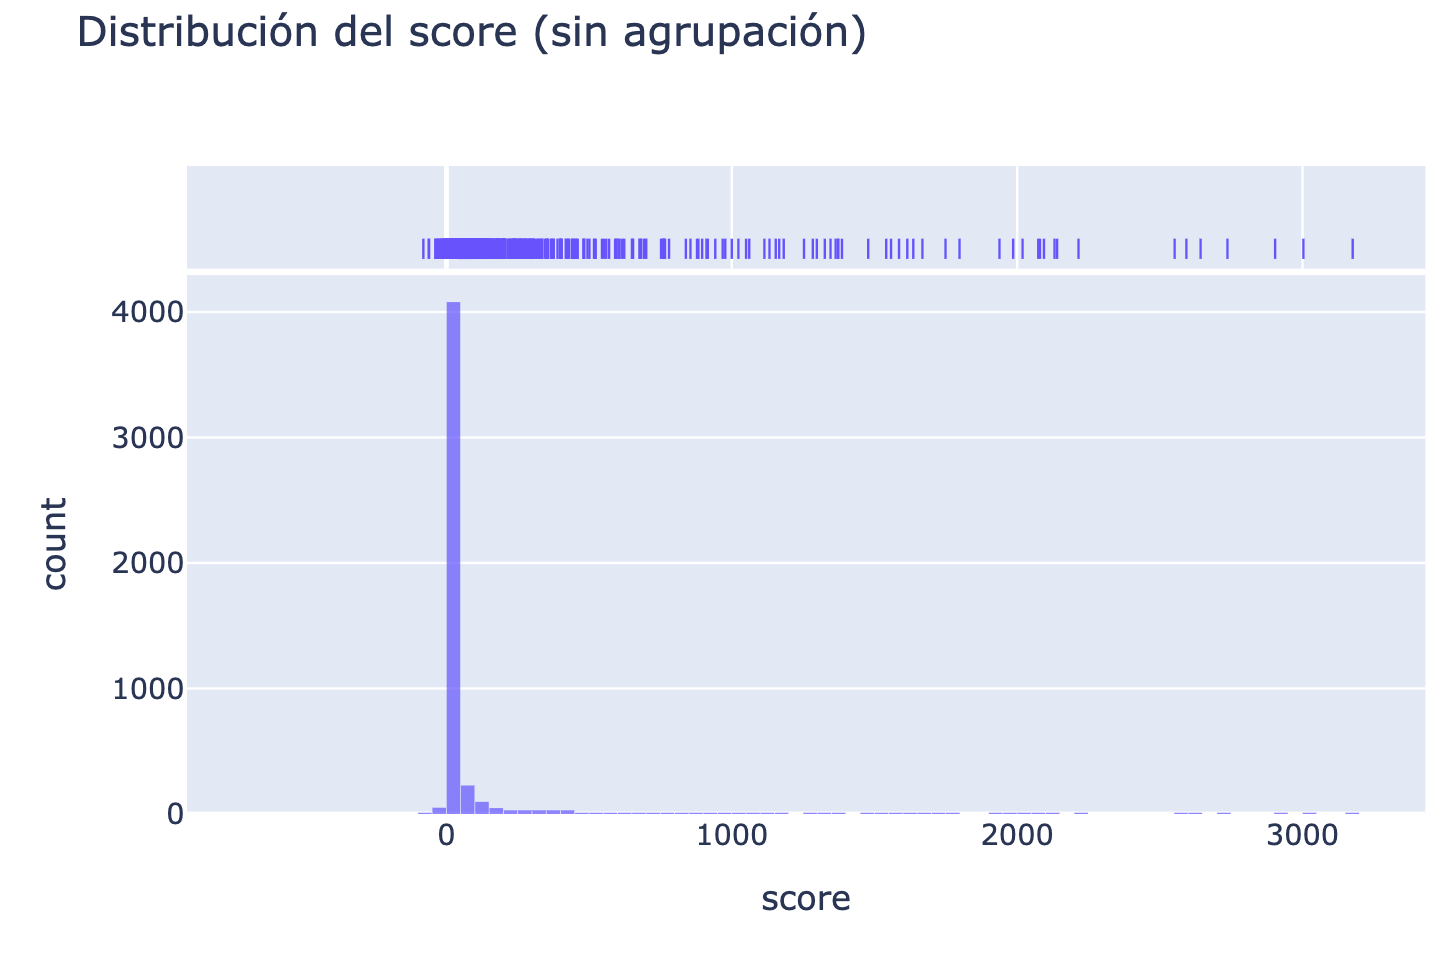

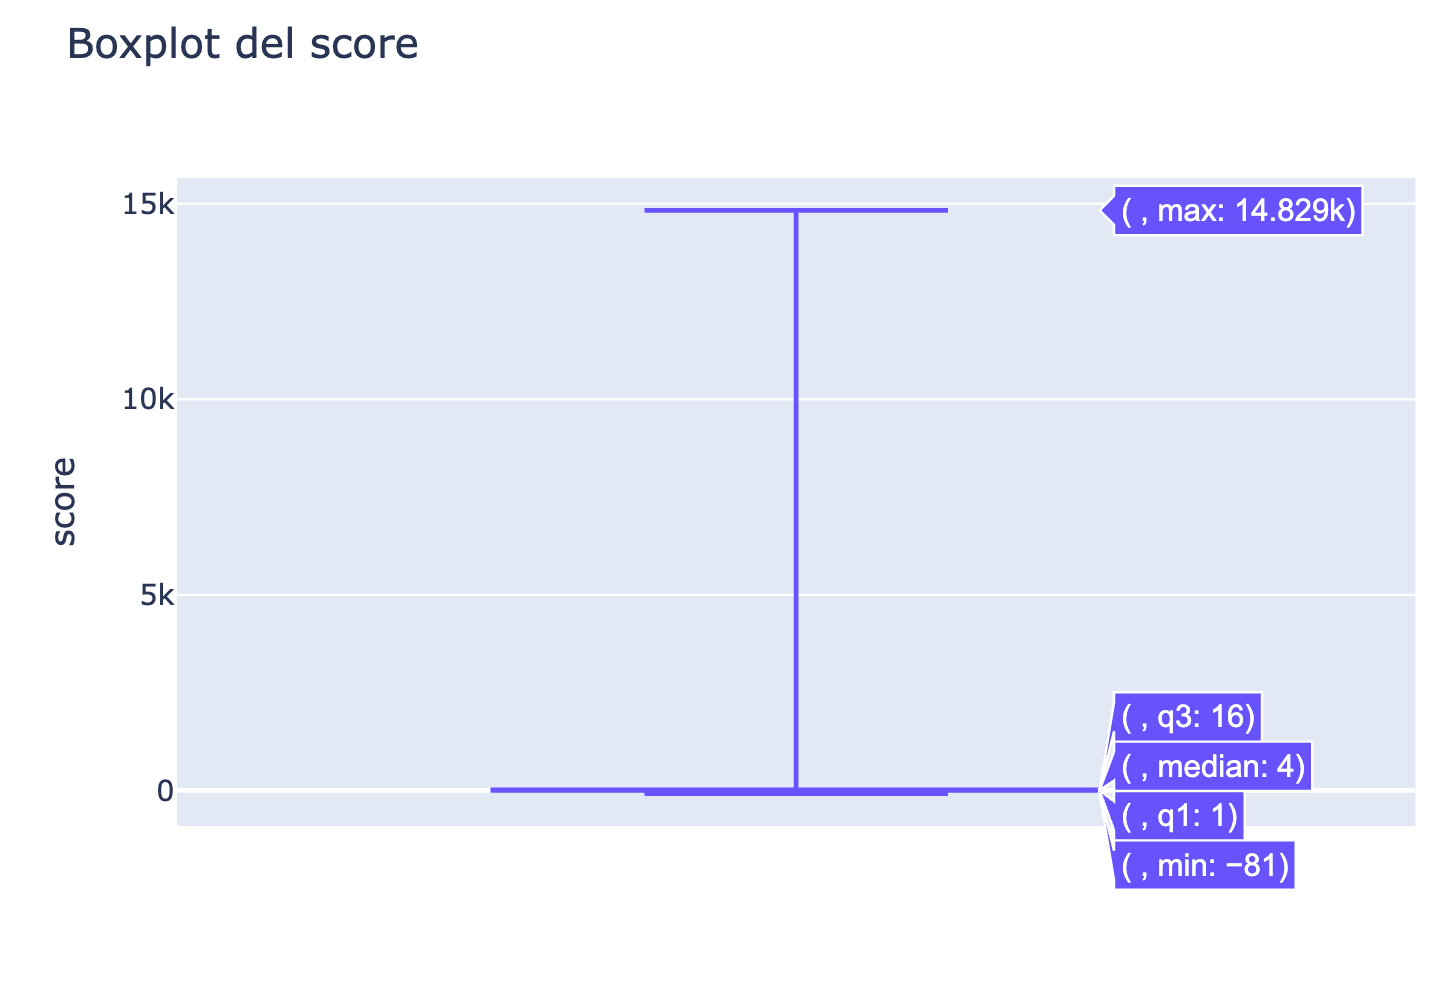

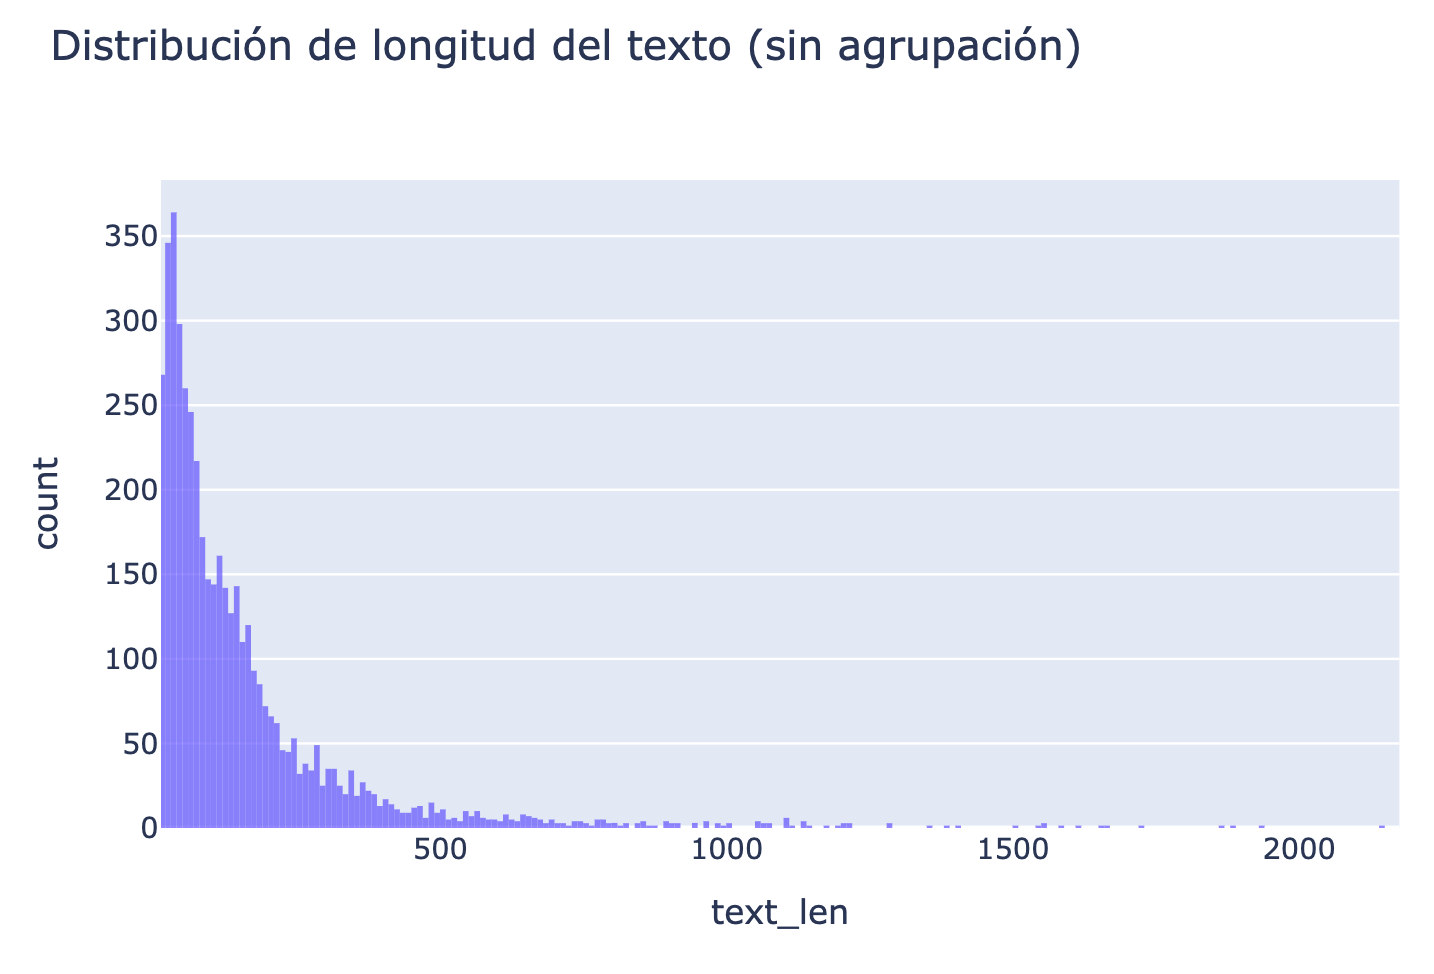

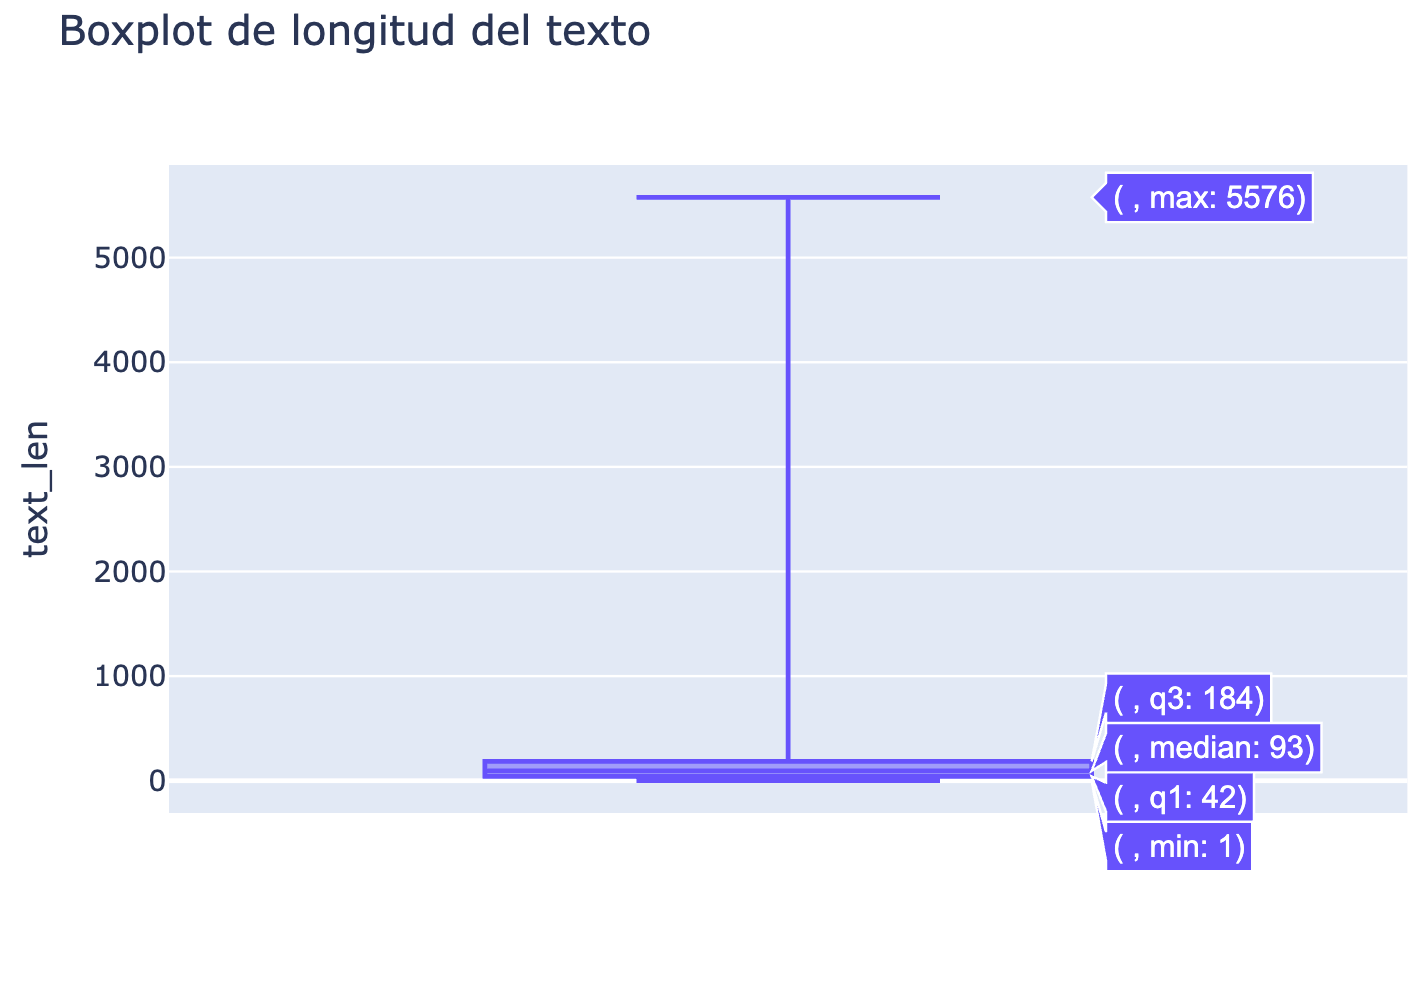


2. Análisis de **correlaciones** entre variables numéricas básicas (`score`, `text_len`, etc.).

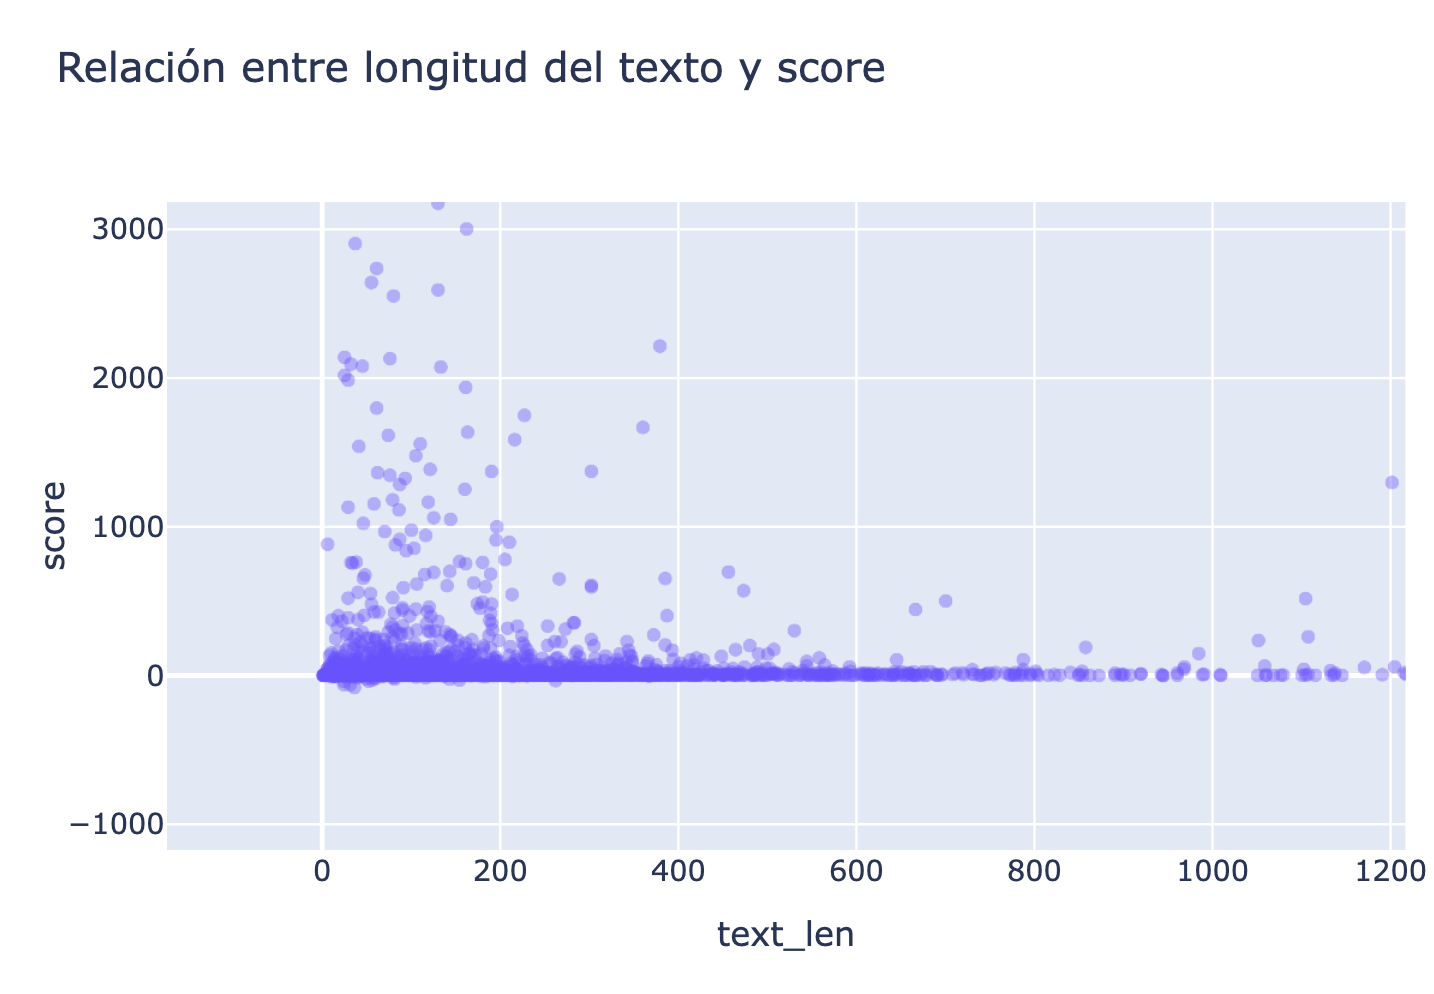

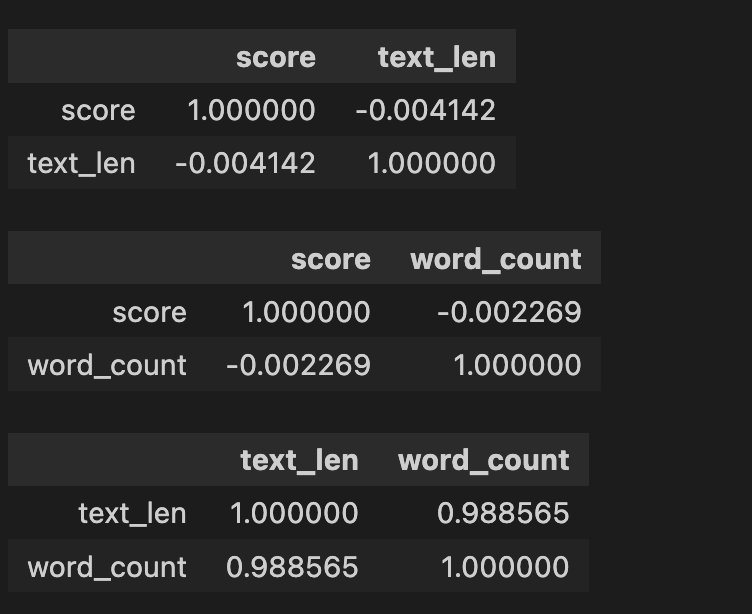

3. Inspección de ejemplos extremos (comentarios con score muy alto o muy bajo).

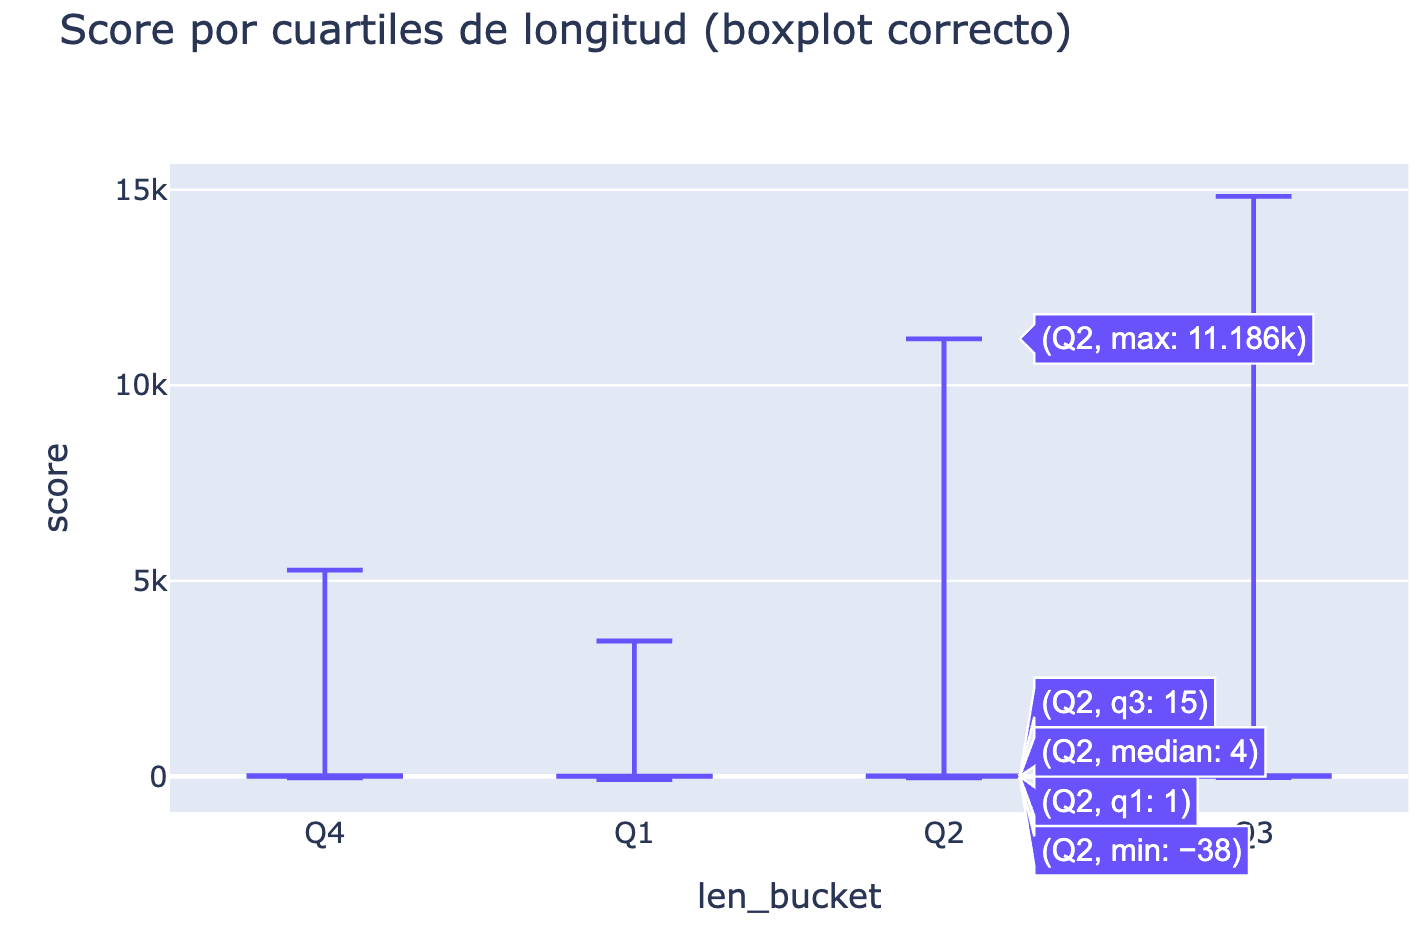

5. Exploracion de **proporcion de signos emocionales en comentarios** segun el score e individualmente. 

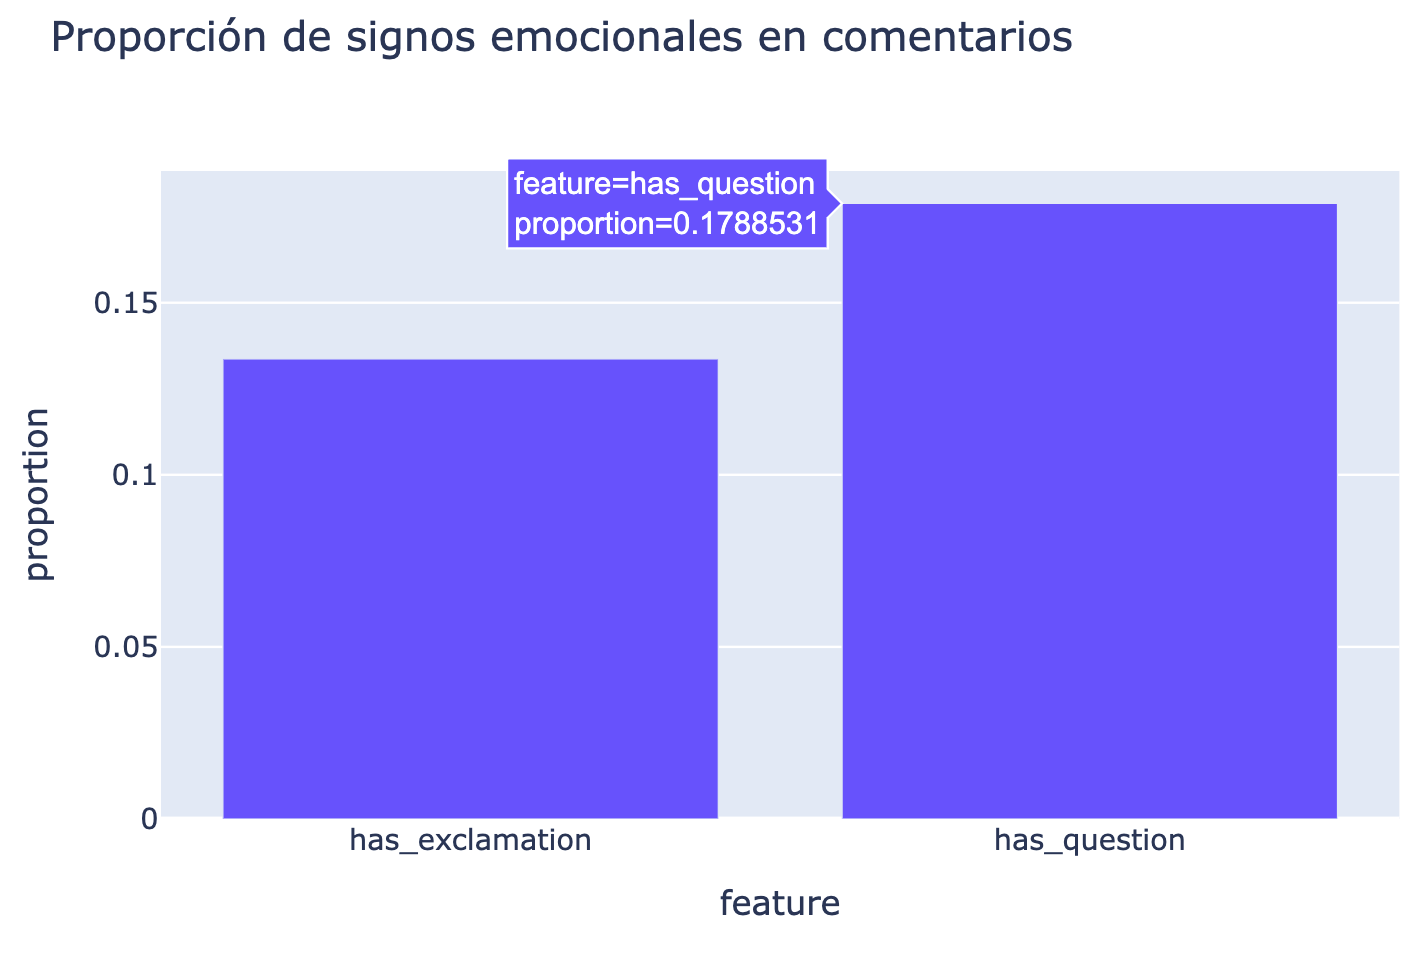

6. Ejemplos:

    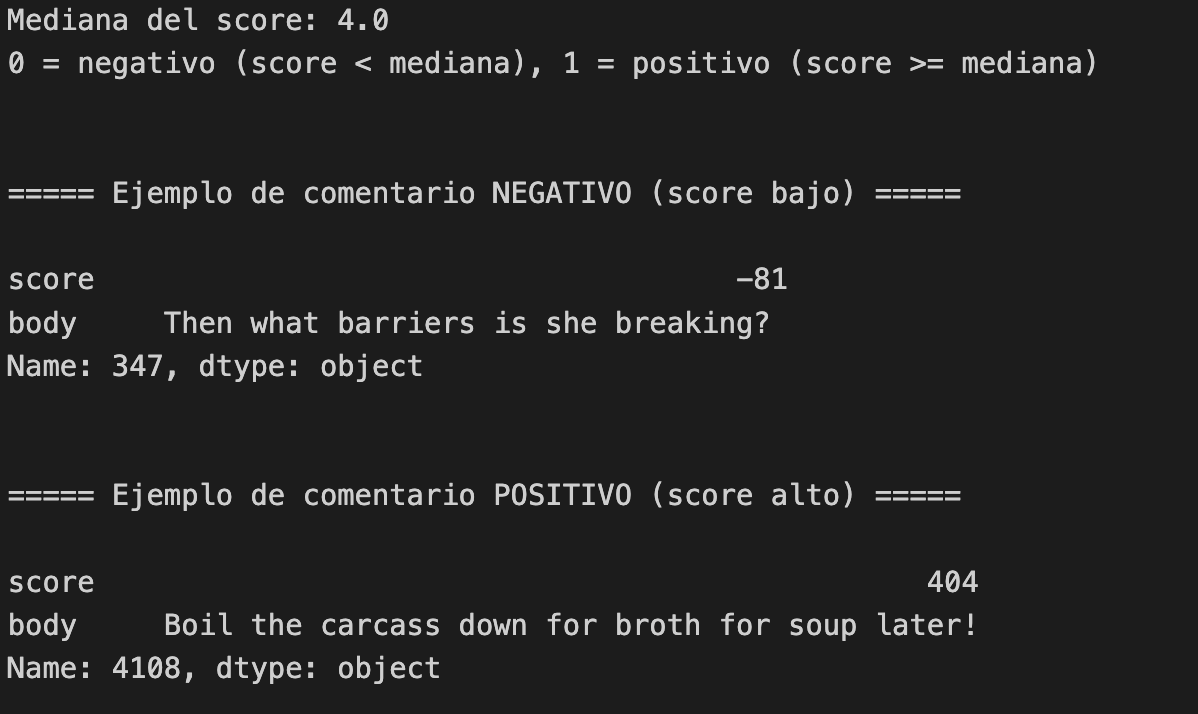

#### 5.1.2 Hallazgos clave

- La distribución de `score` presenta **cola pesada** en la parte alta; unos pocos comentarios concentran scores muy altos. Esto motivó la **winsorización** (`score_clipped`).
- La longitud de los comentarios (`text_len`) es muy variable; hay muchos textos muy cortos que aportan poco contexto semántico.
- La proporción final de la etiqueta binaria `sentiment` queda moderadamente desbalanceada (~54 % positivos vs ~46 % negativos), por lo que se priorizó F1 frente a accuracy.
- Se detectaron comentarios con texto `[deleted]` o `[removed]`, que se eliminaron en la fase de wrangling.

#### 5.1.3 Variables candidatas a ingeniería futura

- Relaciones no lineales entre longitud del comentario y probabilidad de positivo.
- Features de léxico emocional (por ejemplo, conteos de palabras positivas/negativas).
- Señales derivadas de metadatos (`subreddit`, hora del día).

#### 5.1.4 Riesgos detectados

- Posible **data leakage** si se usara el *score* como feature al mismo tiempo que como base para la etiqueta; se decidió no incluirlo como predictor.
- **Desequilibrio moderado de clases**, que hace recomendable usar F1 como métrica principal.
- Ausencia de información sobre idioma; algunos comentarios pueden no estar en inglés, afectando el rendimiento de DistilBERT SST-2.

---

### 5.2 Data Wrangling

#### 5.2.1 Transformaciones aplicadas

En `02_data_wrangling.ipynb` se definió un pipeline de limpieza que produce los datasets en `data/interim` y `data/processed`. Las transformaciones principales fueron:

1. **Filtrado de registros inválidos**:
   - Eliminación de comentarios con texto `[deleted]` o `[removed]`.
   - Eliminación de duplicados exactos sobre `comment_id` si aparecían.

2. **Normalización de texto**:
   - Conversión a minúsculas.
   - Limpieza básica de URLs, *mentions* y caracteres no alfabéticos.
   - Manejo de espacios múltiples y caracteres de control.
   - Resultado en `comments_text_normalized.parquet`.

3. **Ingeniería de features**:
   - `text_len` y `word_count`.
   - Flags booleanos: `has_exclamation`, `has_question`.
   - Consolidación en `comments_features_step2.parquet`.

4. **Manejo de outliers**:
   - Winsorización ligera de `score` y `text_len` → `score_clipped`, `text_len_clipped` para reducir el impacto de valores extremos.

5. **Construcción de la etiqueta**:
   - Definición de `sentiment` binario a partir de la mediana de `score_clipped`.

6. **Split de datos**:
   - División en `train/val/test` estratificada por `sentiment` y exportación a `data/processed/sentiment_{train,val,test}.parquet`.

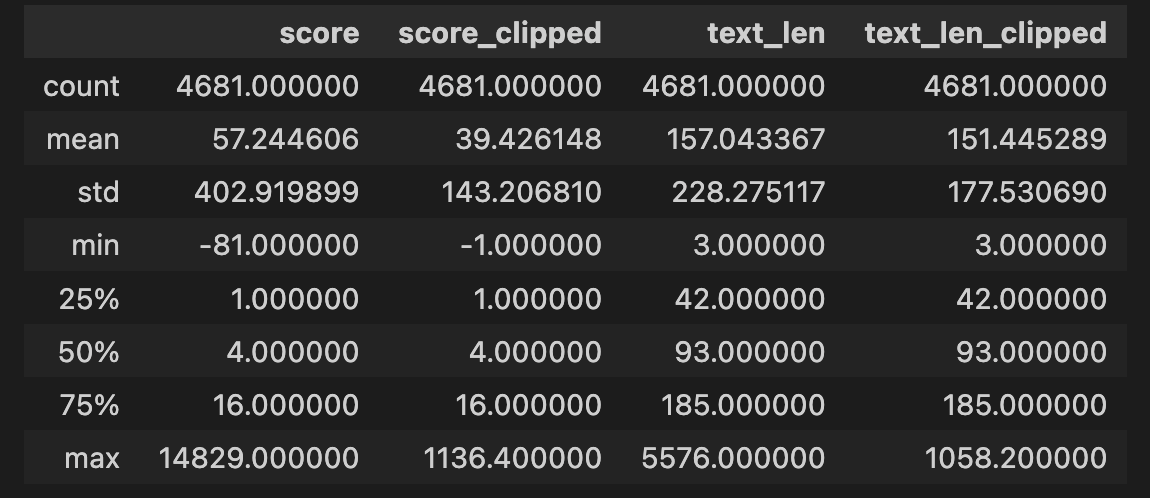

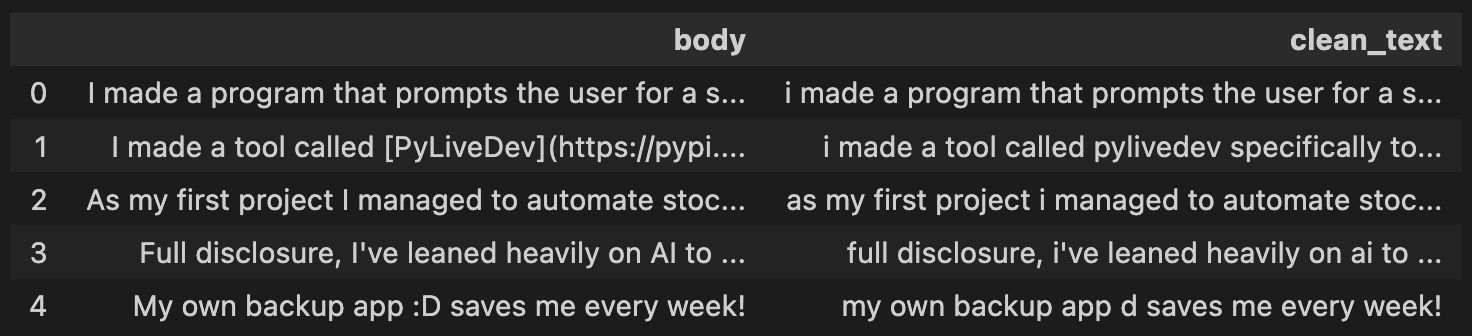


#### 5.2.2 Justificación de las transformaciones

- La limpieza mínima del texto busca un equilibrio entre normalización y conservación del estilo original del usuario.
- La winsorización permite mantener todos los registros sin que unos pocos outliers dominen la escala.
- La estratificación del split asegura que las proporciones de clases se mantengan en train/val/test.
- No se aplicó *lemmatization* ni *stemming* explícitos porque los modelos basados en Transformers ya aprenden representaciones robustas del texto original.

#### 5.2.3 Resultado final

El dataset procesado tiene, a alto nivel:

- Columnas clave: `clean_text`, `score_clipped`, `text_len_clipped`, `word_count`, `has_exclamation`, `has_question`, `sentiment`.
- Tipos: texto, numéricos (int/float) y booleanos.
- Conteo de filas: ~3.2k train, ~700 val, ~700 test.

La referencia técnica completa se encuentra en `02_data_wrangling.ipynb`.

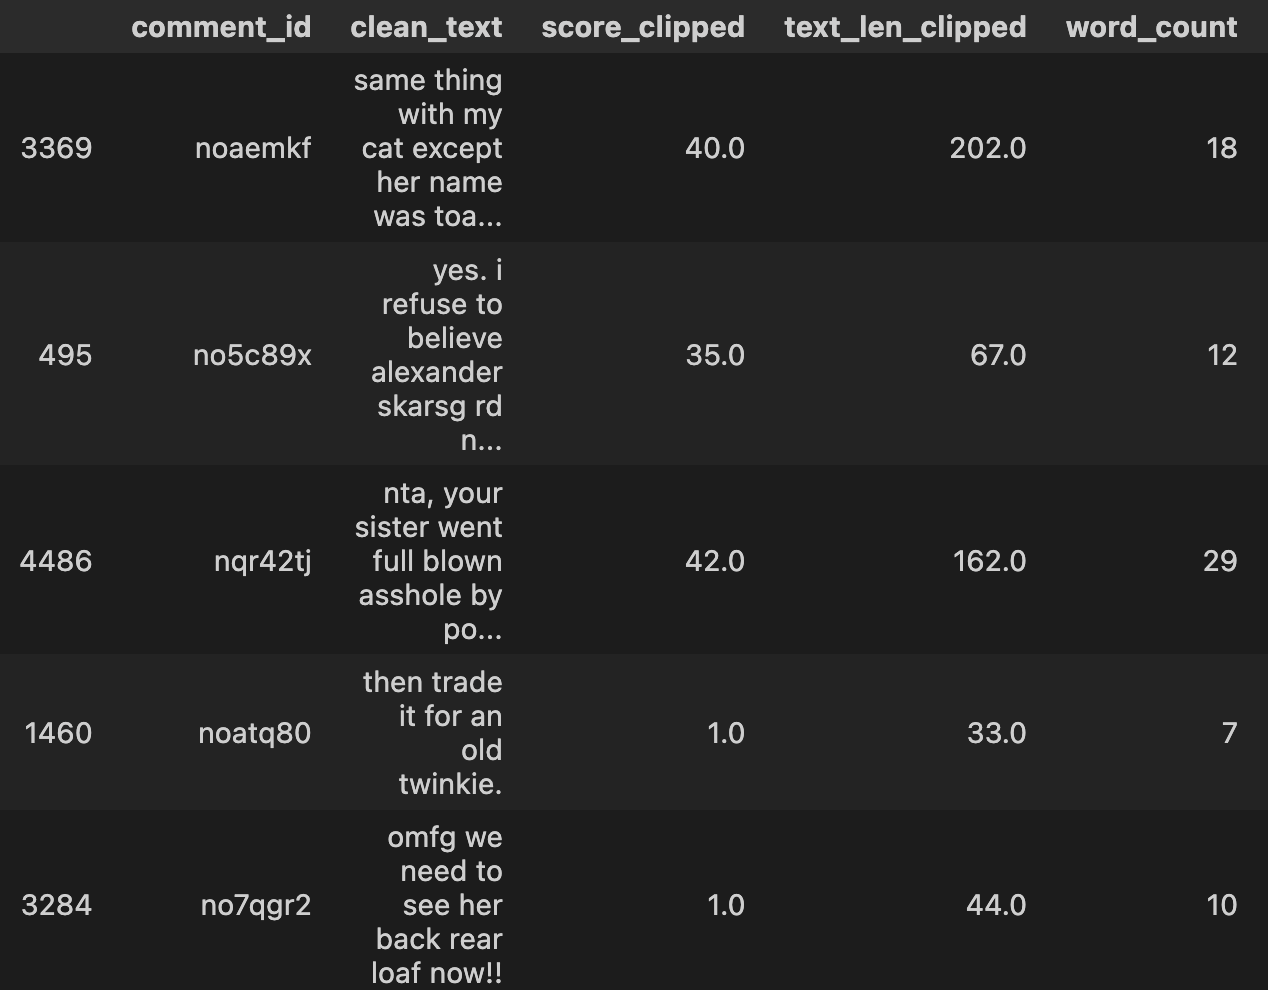

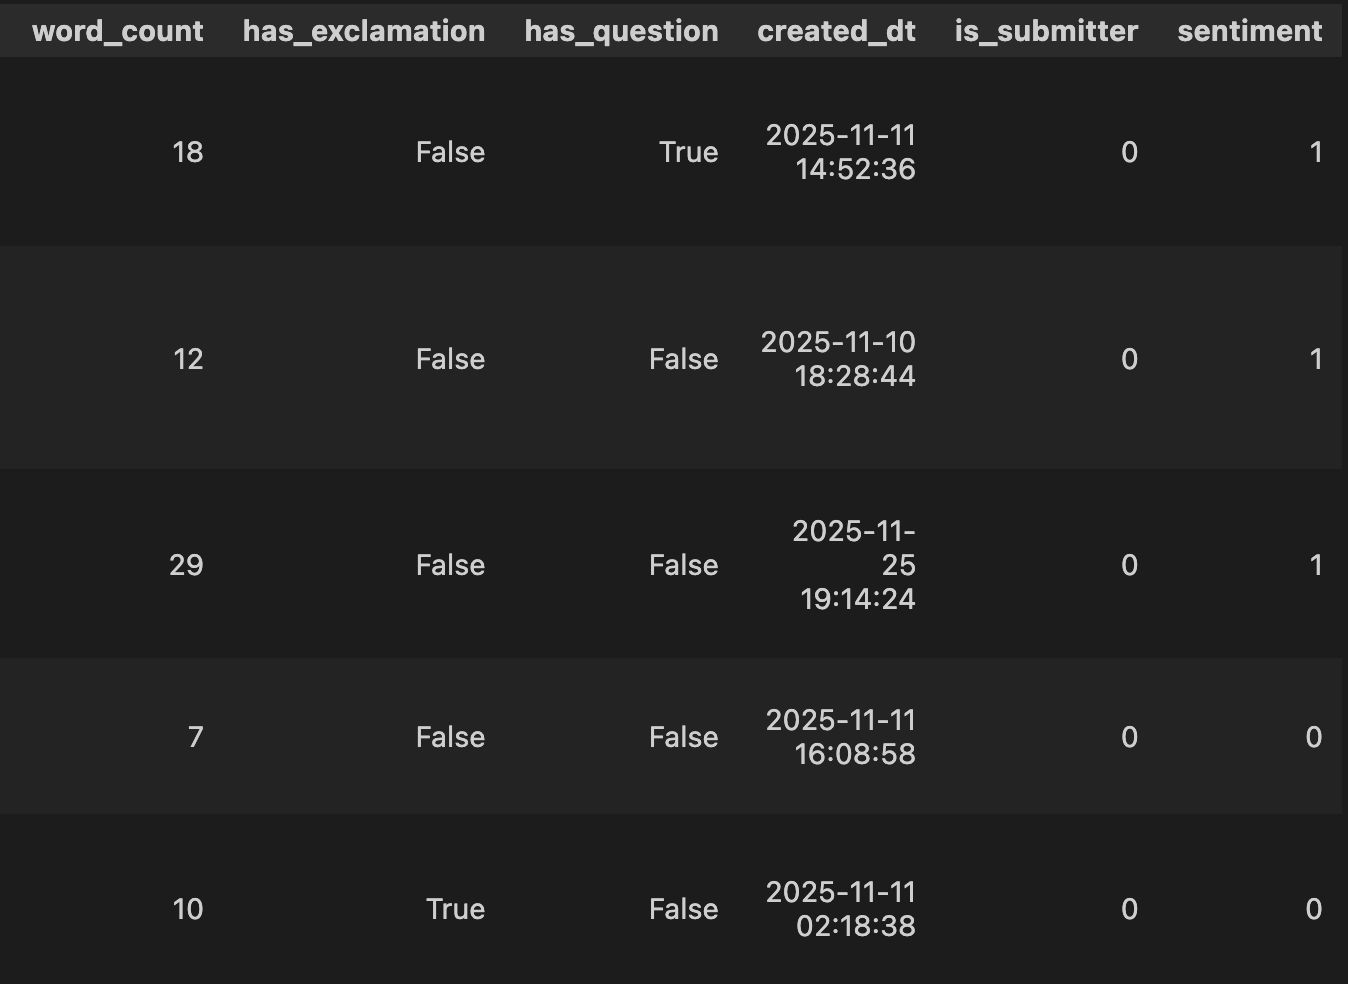


---

### 5.3 Entrenamiento del modelo con MLflow

#### 5.3.1 Familias de modelos entrenadas

En `03_training_model.ipynb` y en `src/pipelines/train_pipeline.py` se entrenaron/evaluaron tres configuraciones:

1. **BERT multilingüe**  
   - Modelo: `nlptown/bert-base-multilingual-uncased-sentiment`.  
   - Uso: inferencia directa, sin *fine-tuning*.  
   - Conversión 5 clases → binario (1–2 negativo, 3 neutro, 4–5 positivo).

2. **DistilBERT SST-2**  
   - Modelo: `distilbert-base-uncased-finetuned-sst-2-english`.  
   - Uso: inferencia directa en inglés (2 clases: neg/pos).

3. **MLP + SentenceTransformer (modelo “deep clásico”)**  
   - Embeddings: `sentence-transformers/all-MiniLM-L6-v2` (384 dimensiones).  
   - Clasificador: `MLPClassifier` de scikit-learn con **HPO de hiperparámetros** (tamaño de capa oculta, `alpha`, `learning_rate_init`, `batch_size`, `max_iter`) usando Hyperopt.

#### 5.3.2 Configuración base de entrenamiento

- Partición fija train/val/test desde `data/processed`.
- Entrenamiento siempre en `train`, selección de modelo y tuning en `val`, evaluación final en `test`.
- Métrica objetivo de HPO: `val_f1` (F1 binario en validación).

#### 5.3.3 Registro en MLflow

- Se creó el experimento:  
  `EXPERIMENT_NAME = "/Users/marianasgg19@gmail.com/EMI/imedia/Sentiment_BERT_MLP"`.
- Para cada run se loggean:
  - Parámetros: tipo de modelo, nombre del checkpoint HF, hiperparámetros del MLP.
  - Métricas: `val_accuracy`, `val_f1`, `test_accuracy`, `test_f1`.
  - Artefactos:
    - Tokenizers BERT (`preprocesador/..._tokenizer_NTBK_*`).
    - Embeddings `train/val/test` (`embeddings/*.npy` + metadata JSON).
    - Modelos scikit-learn (`model/`).
    - Preprocesador `StandardScaler` (`preprocessor_scaler_NTBK`).

#### 5.3.4 HPO con Hyperopt

Detalles del proceso HPO aplicado al MLP:

- **Librería:** Hyperopt  
- **Espacio de búsqueda:**
  - `hidden_layer_sizes` ∈ {(128,), (256,), (512,)}
  - `alpha` ~ log-uniforme [1e-5, 1e-1]
  - `learning_rate_init` ~ log-uniforme [1e-4, 5e-3]
  - `batch_size` ∈ {64, 128, 256}
  - `max_iter` ∈ {5, 10, 20}
- **Evaluaciones:** `MAX_EVALS = 20`
- **Función objetivo:** minimizar `loss = -val_f1`
- **Estructura de MLflow:**
  - Run padre: `mlp_transformer_embeddings_HPO_FLOW_NTBK`
  - Runs anidados por cada trial: `mlp_hpo_trial`
- El mejor modelo se reentrena completo y se registra en UC con firma (`infer_signature`) y artifacts (scaler, embeddings, metadata).


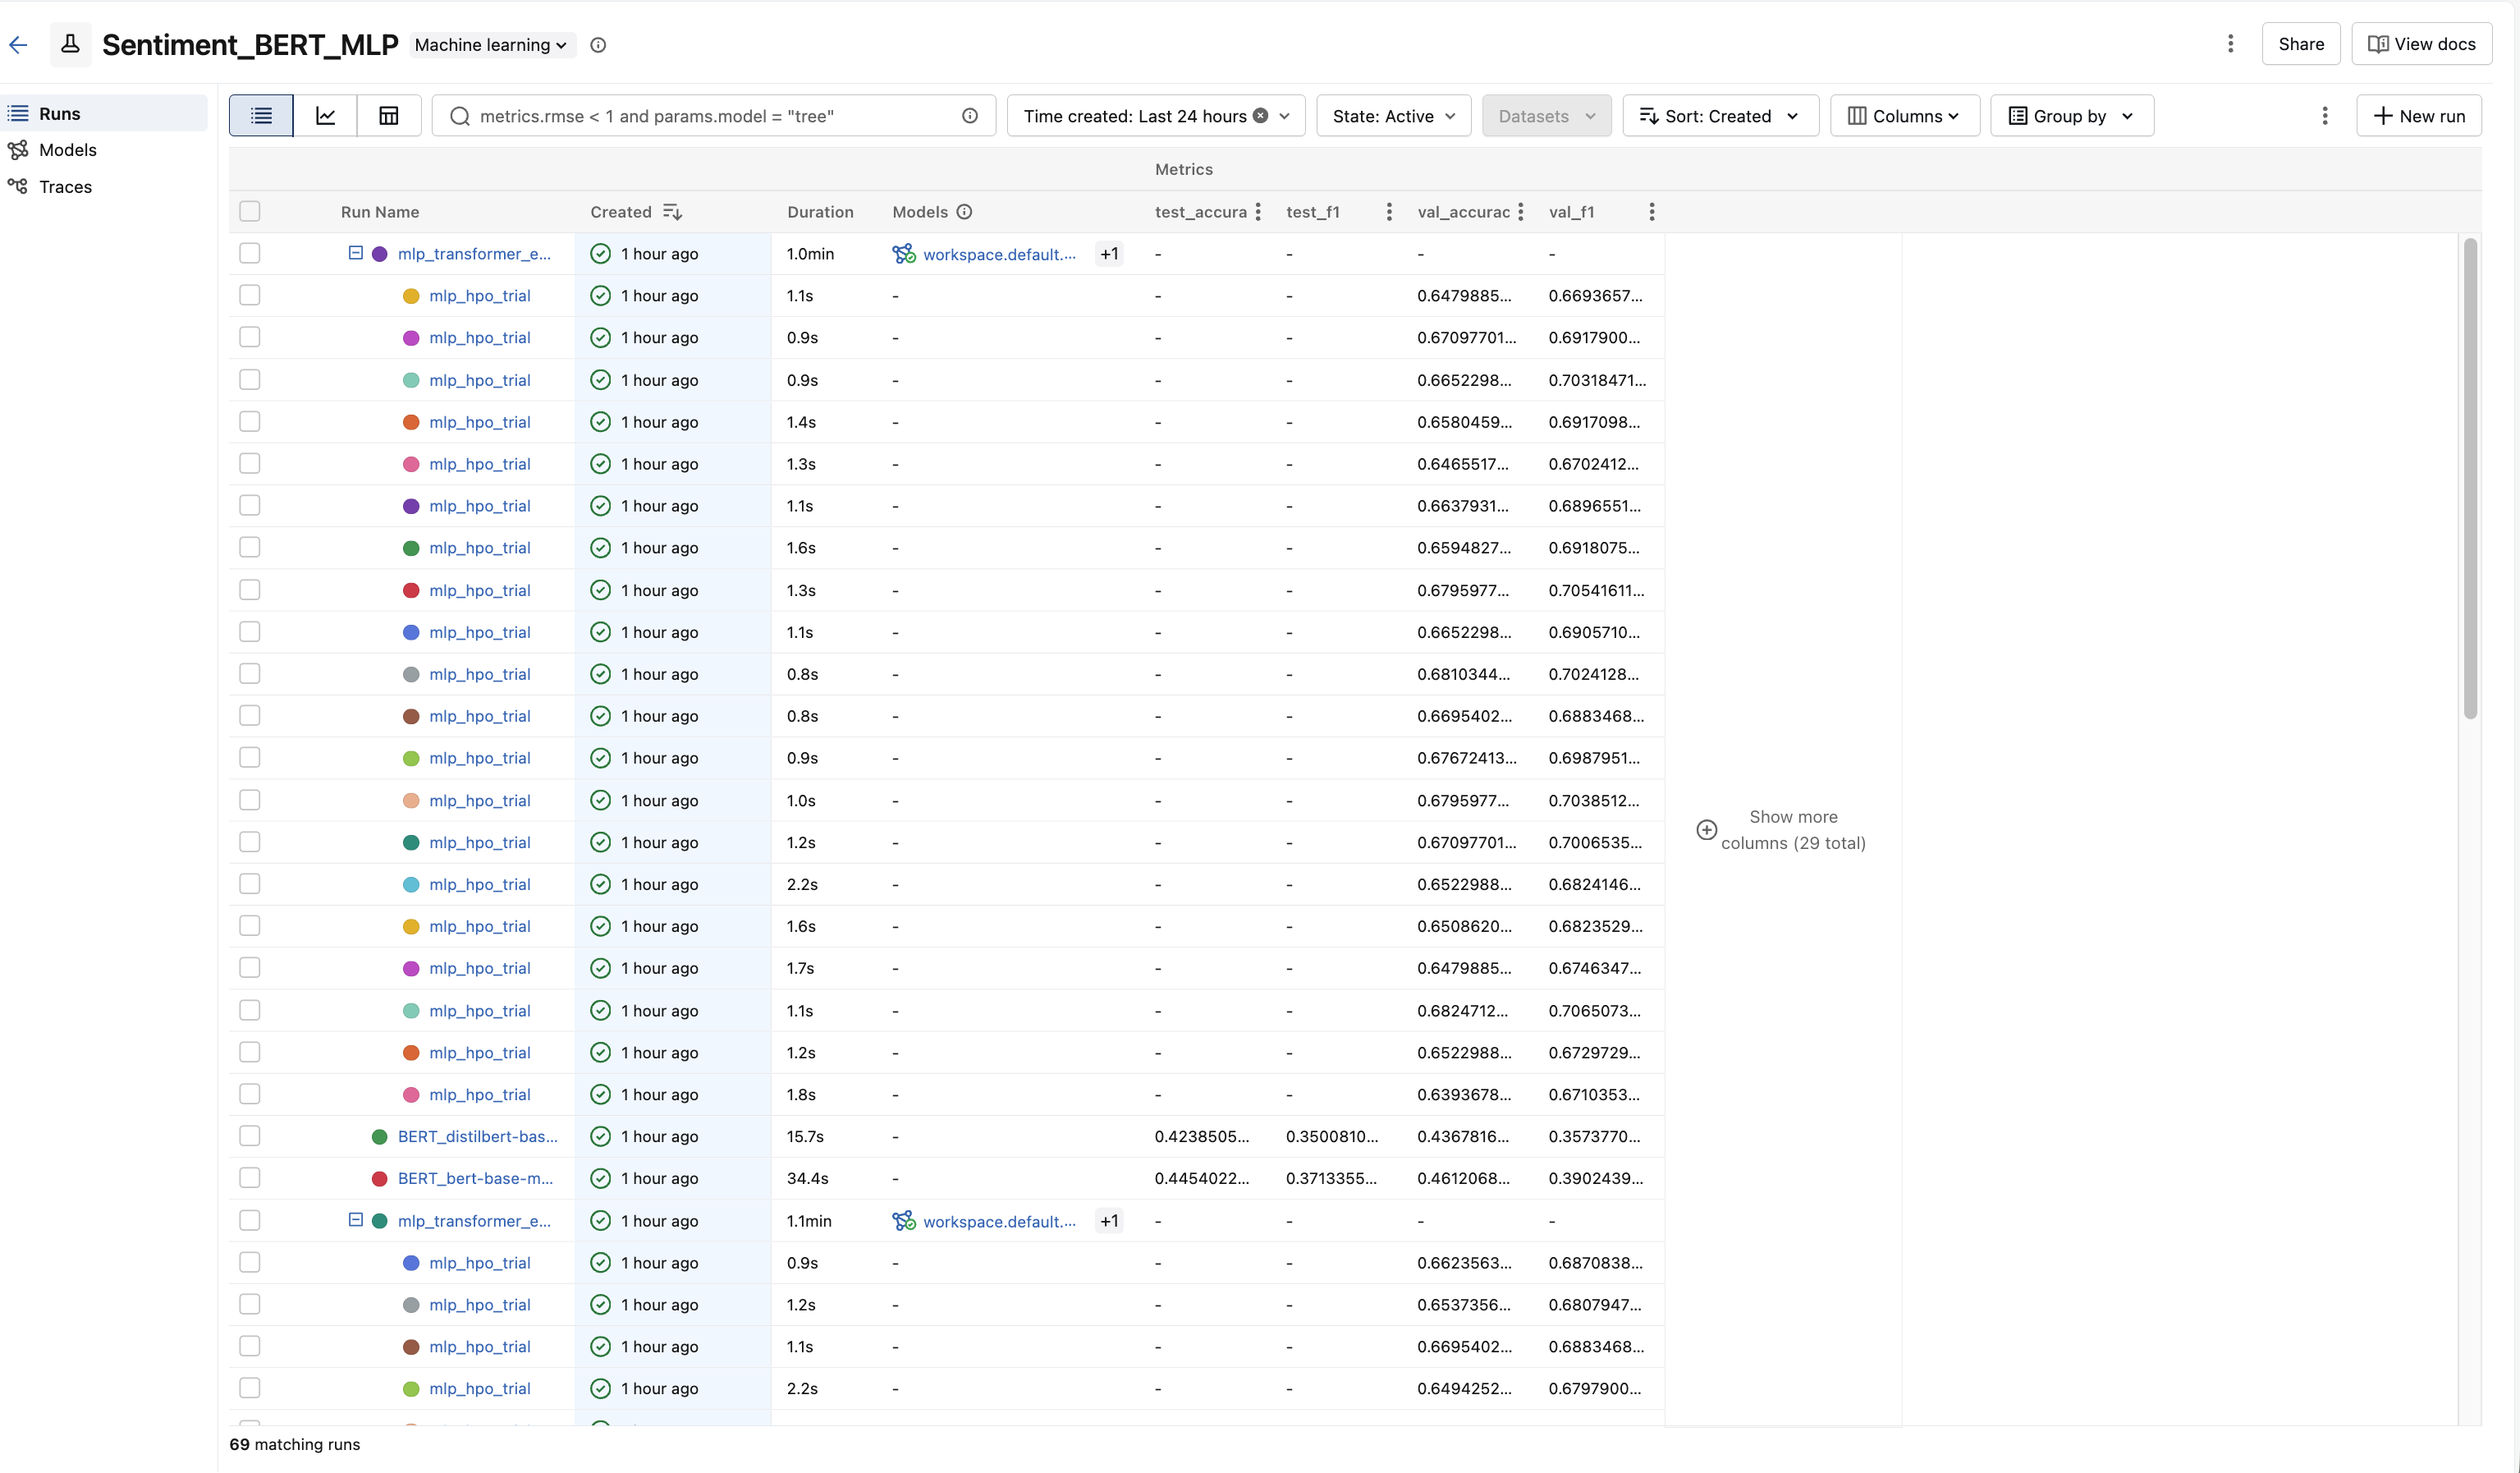

---

### 5.4 Selección del mejor modelo

#### 5.4.1 Criterio objetivo

El modelo se selecciona ordenando la tabla consolidada por **`val_f1` descendente**. Se valida que:

- El F1 en test sea coherente (sin caída pronunciada).
- El modelo sea viable en costo/latencia para uso interactivo.

#### 5.4.2 Resultados comparados

La tabla consolidada final (ordenada por `val_f1`) muestra:

- `mlp_transformer`  
  - `val_f1 ≈ 0.7143`, `test_f1 ≈ 0.7092`.  
  - `val_accuracy ≈ 0.684`, `test_accuracy ≈ 0.685`.  
  - Gap F1 val-test muy pequeño (~0.005), lo que indica buena estabilidad.

- `bert_bert-base-multilingual-uncased-sentiment`  
  - `val_f1 ≈ 0.3902`, `test_f1 ≈ 0.3713`.

- `bert_distilbert-base-uncased-finetuned-sst-2-english`  
  - `val_f1 ≈ 0.3574`, `test_f1 ≈ 0.3501`.

1) 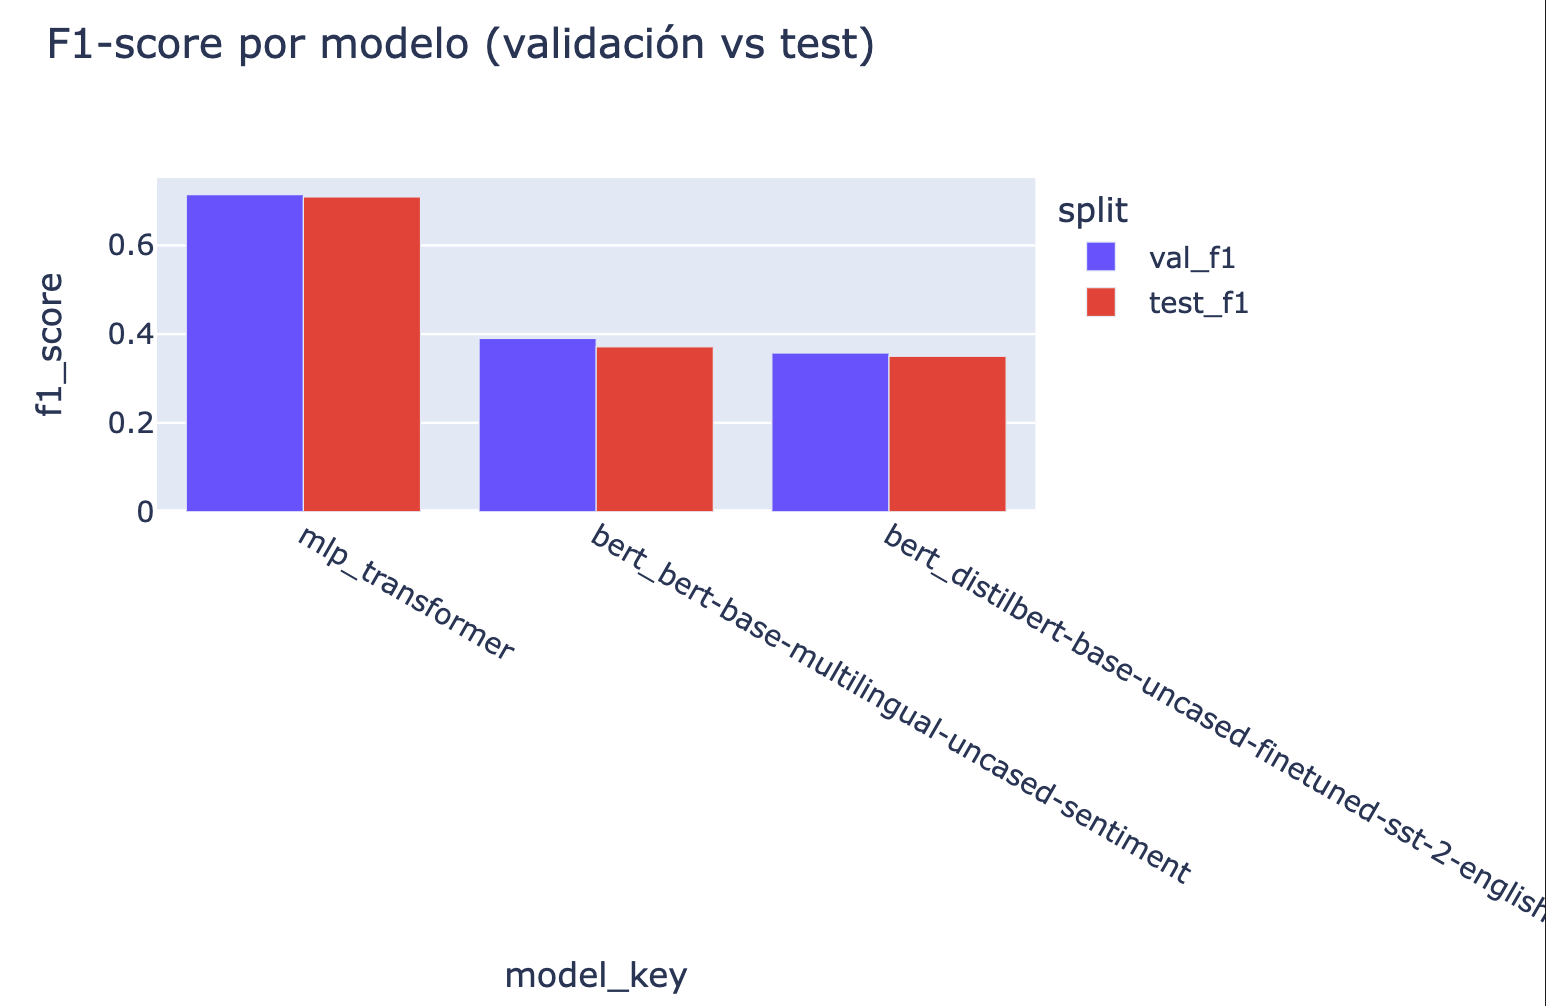  

2) 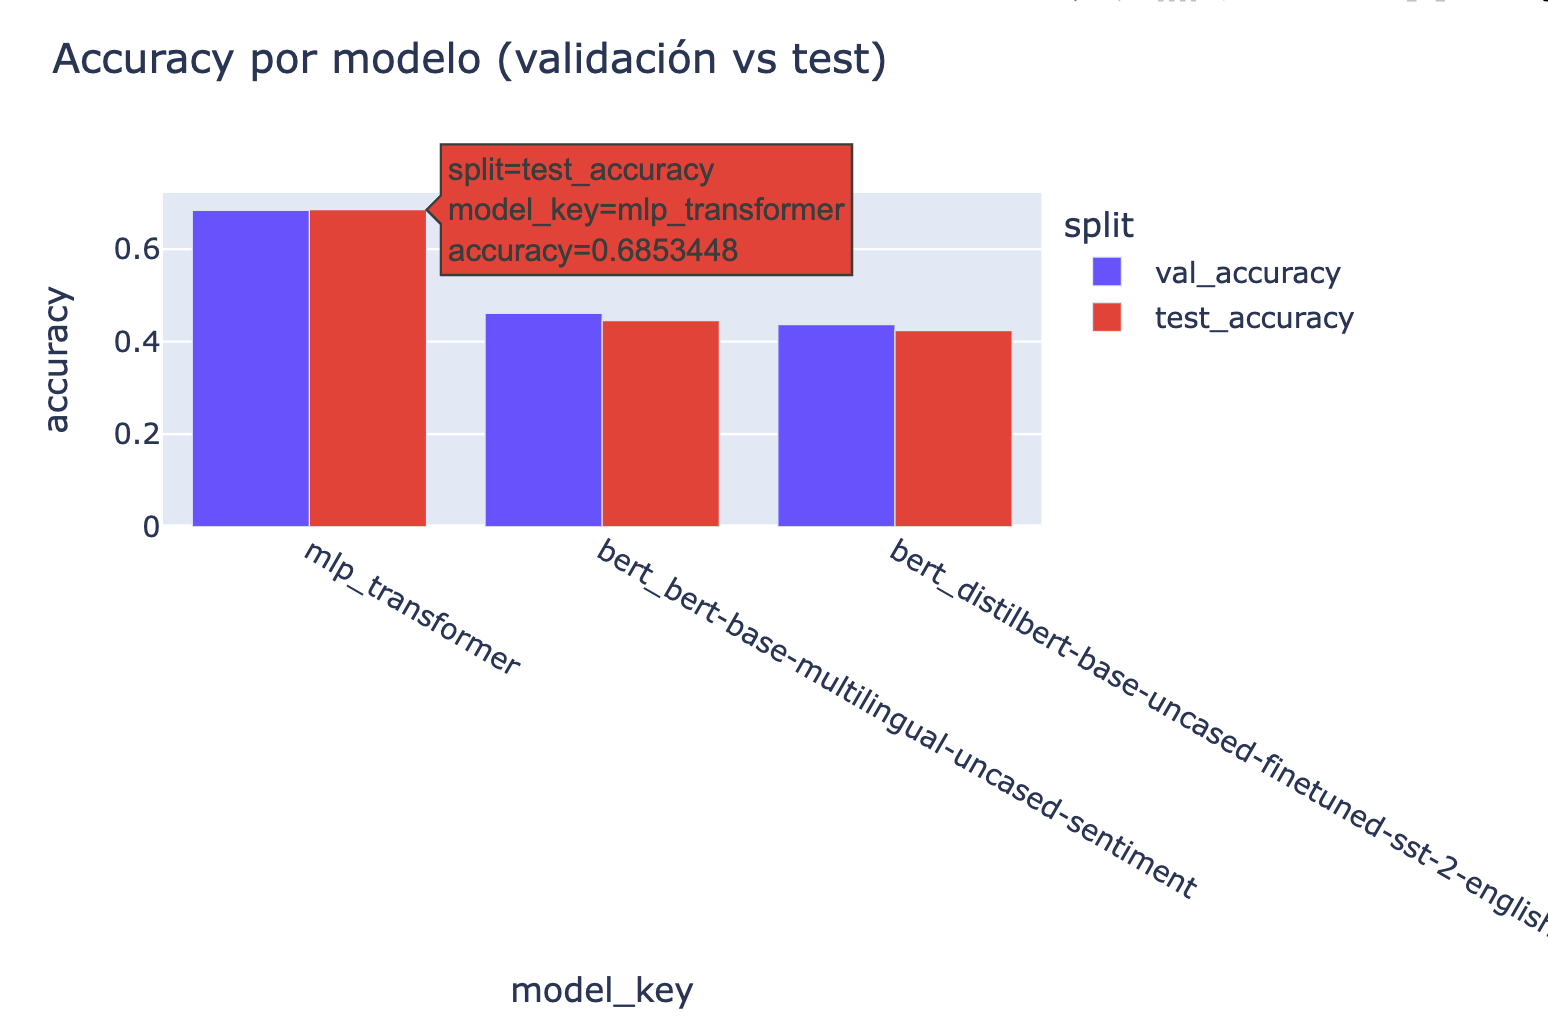  

3) 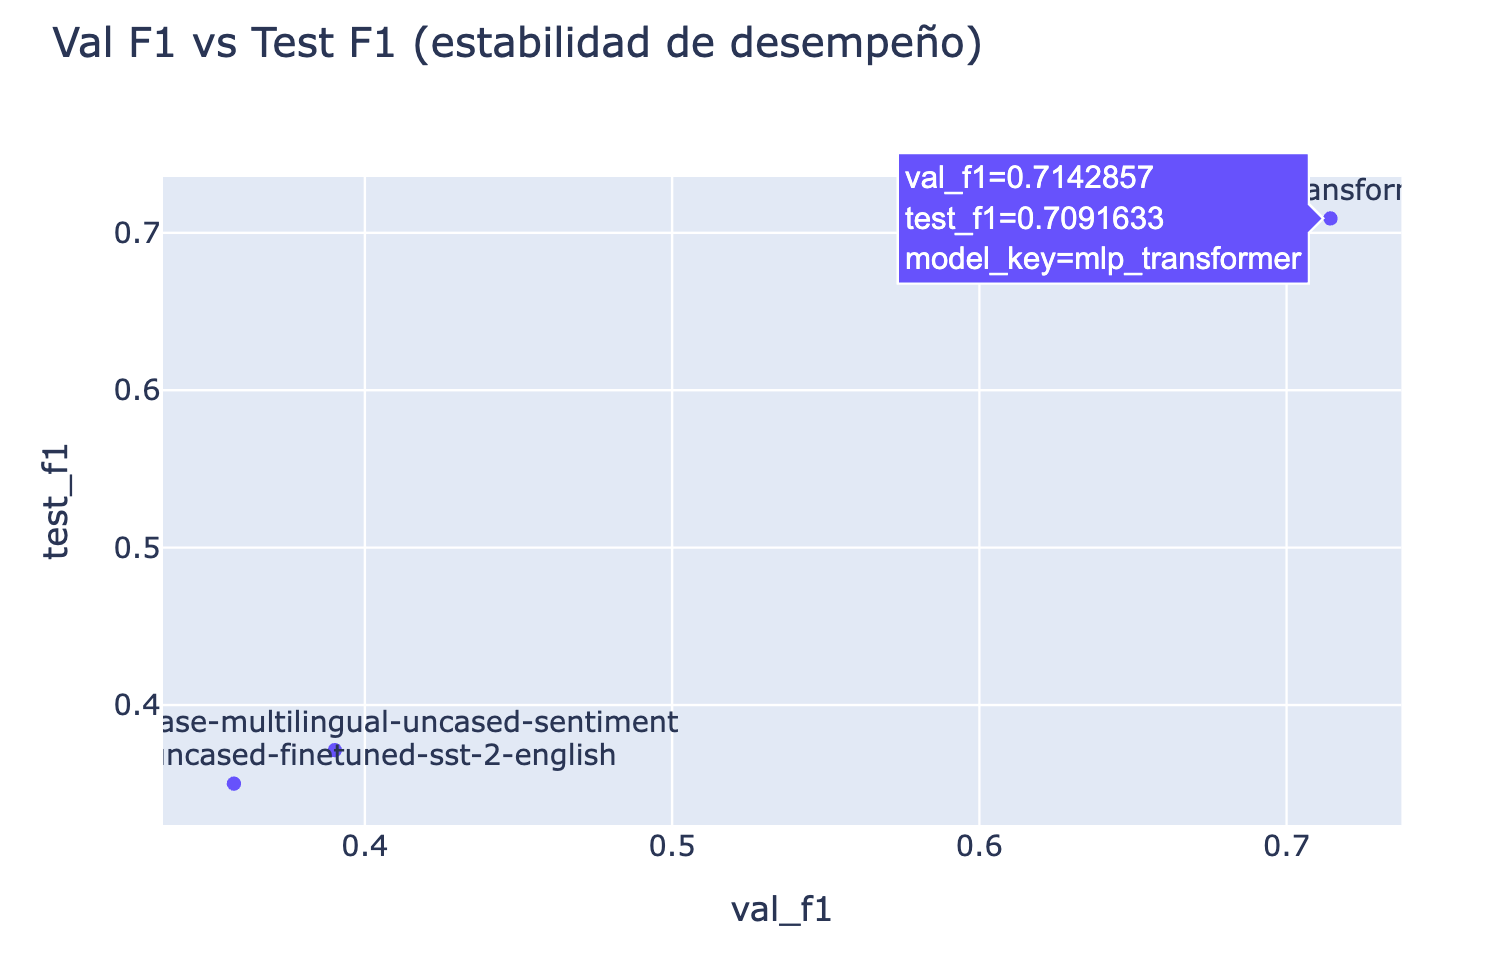

#### 5.4.3 Justificación final

- El **MLP + SentenceTransformer** es el **mejor modelo en F1** tanto en validación como en test, con diferencias claras frente a los BERTs de referencia.
- El gap F1 val-test es pequeño, indicando **poco overfitting** y desempeño estable.
- A nivel operativo:
  - BERT multilingüe ofrece menor rendimiento y mayor costo/latencia.
  - DistilBERT es más ligero, pero sigue sin superar al MLP.
  - El MLP sobre embeddings precalculados es **barato, rápido y sencillo de desplegar**.

Por estos motivos, el modelo seleccionado para producción es `mlp_transformer`.

#### 5.4.4 Registro en el Model Registry

- Nombre UC: `workspace.default.EMI_imedia_sentiment_deep_model_NTBK`.
- Registro:
  - Se loggea el pipeline completo `StandardScaler + MLPClassifier`.
  - Se incluye firma (`infer_signature`) e `input_example`.
- Alias:
  - En el flow de entrenamiento se busca la última versión del modelo y se asigna alias **`champion`** si el MLP es el modelo ganador.
- Los BERTs se mantienen como **baselines de referencia**, pero no se registran en UC en esta iteración.

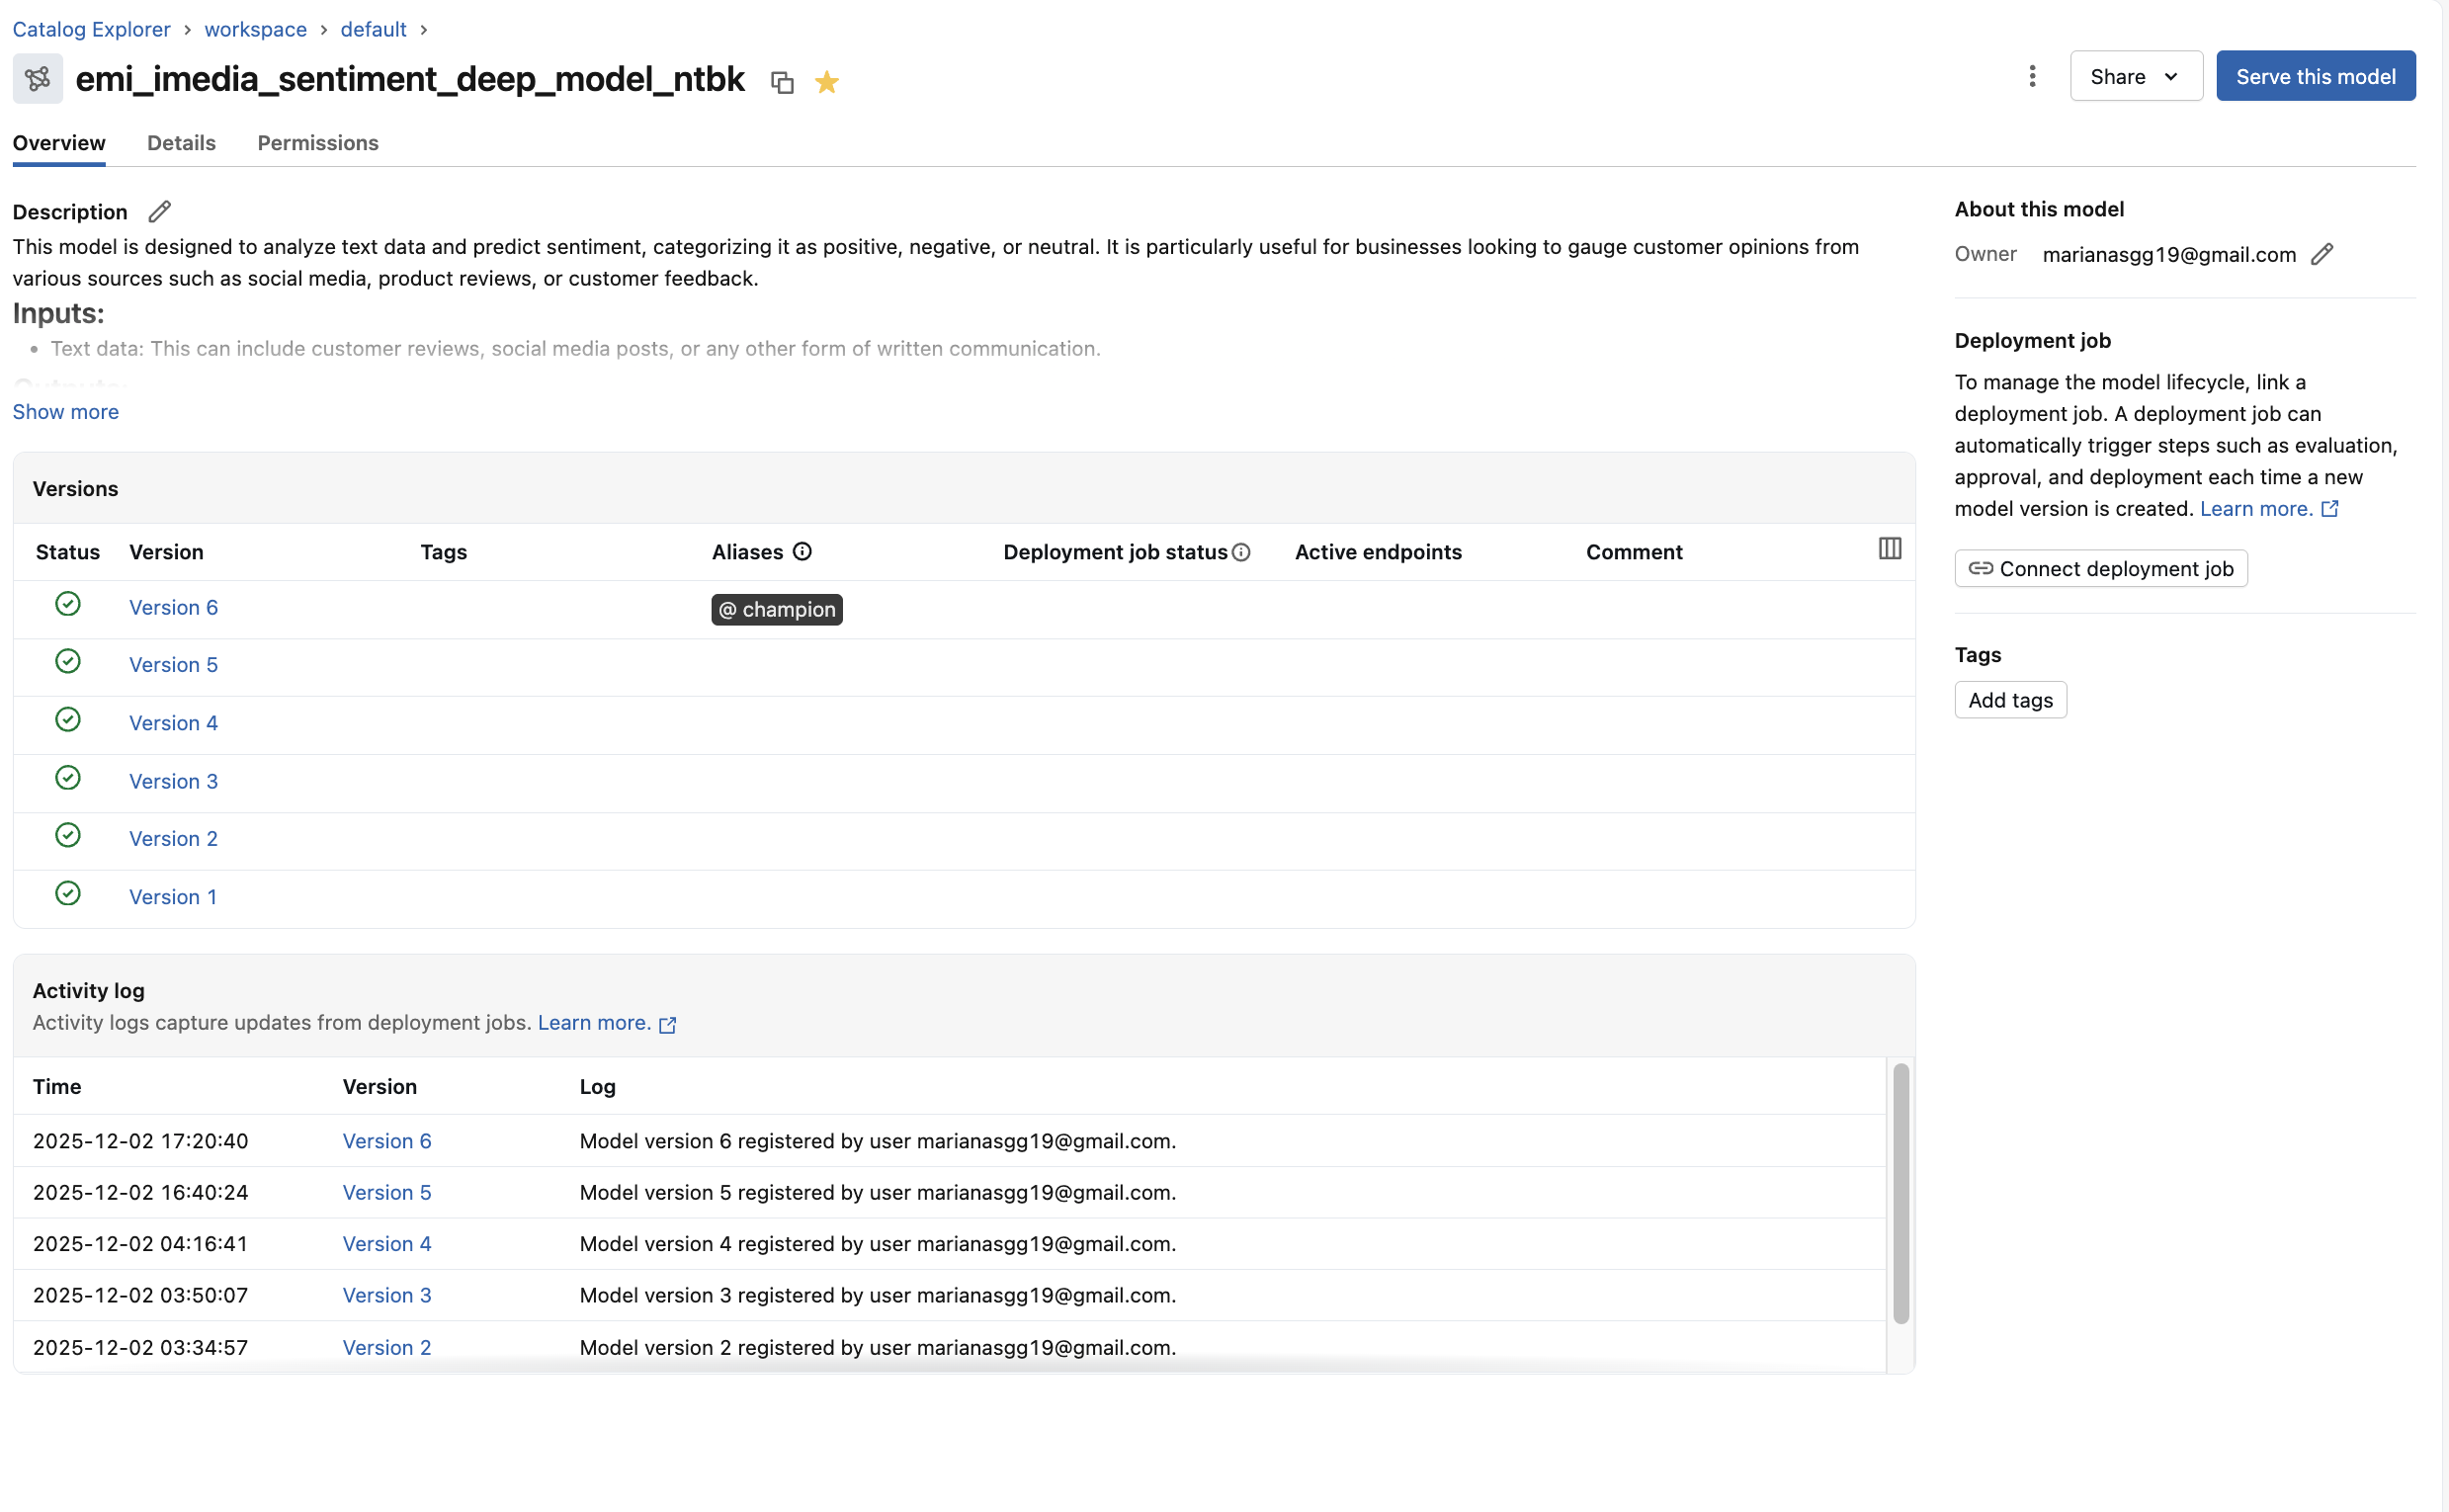

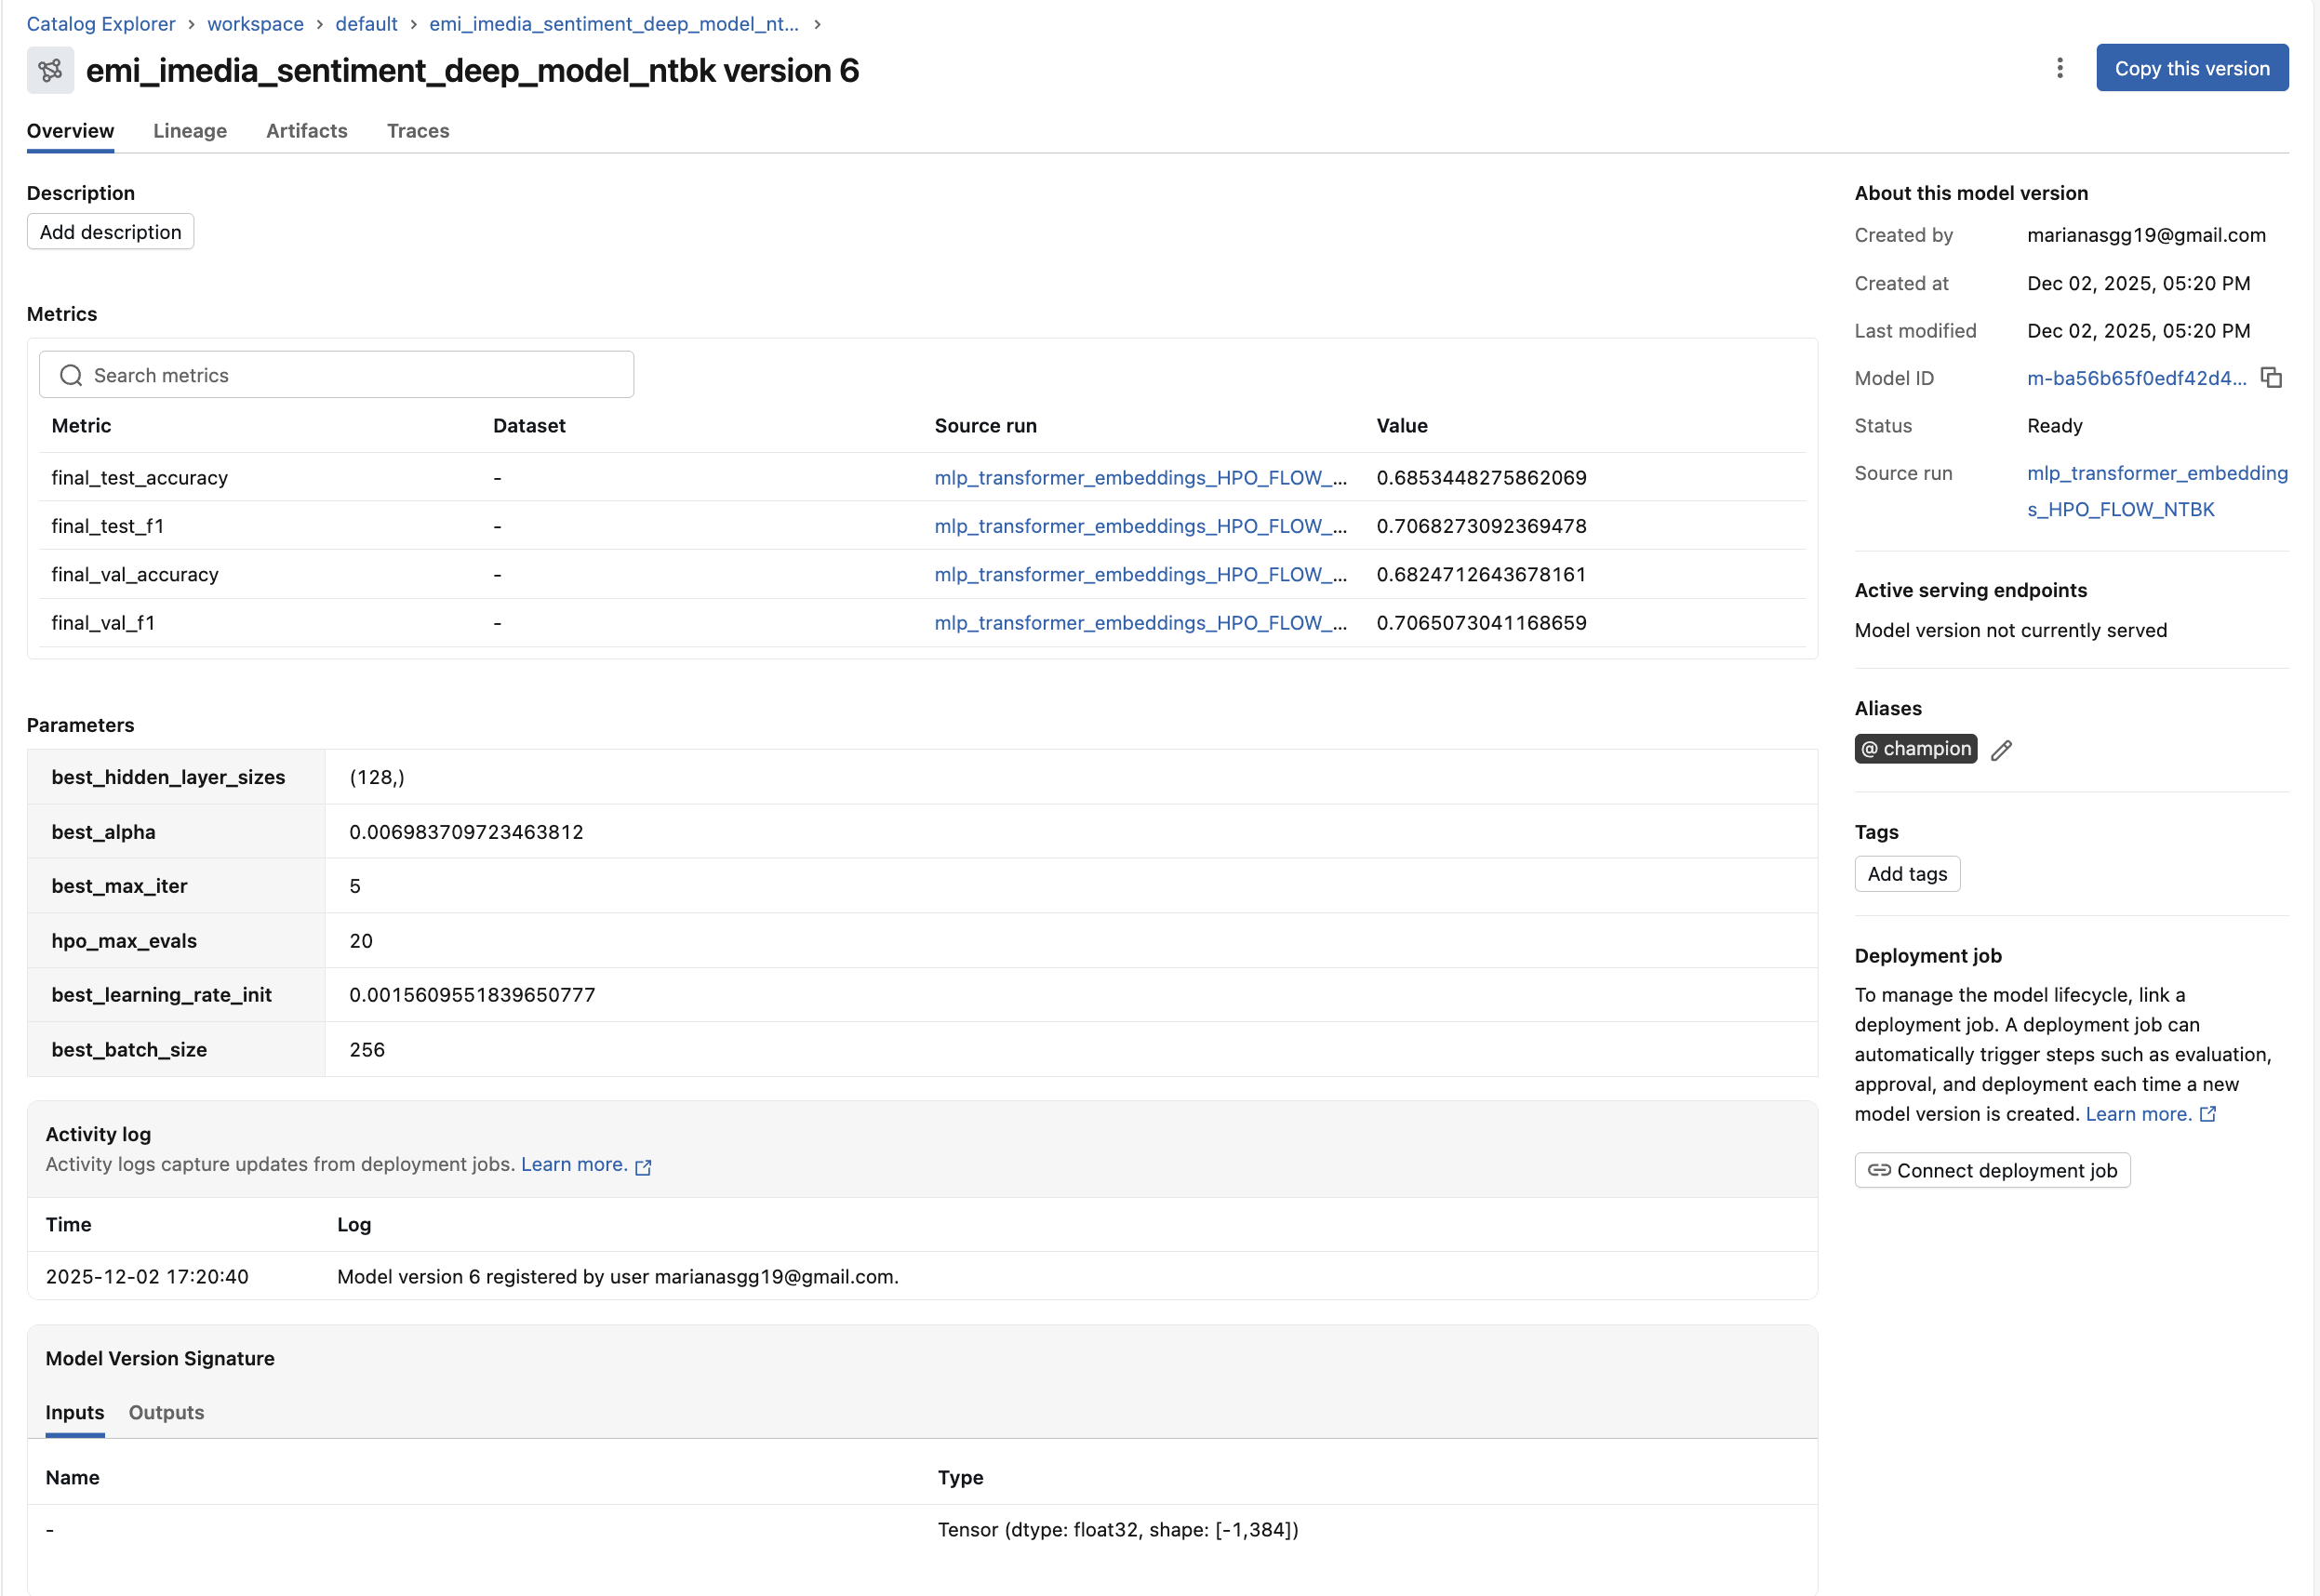

---

### 5.5 Orquestación – Training Pipeline (Prefect)

#### 5.5.1 Descripción del flujo

El archivo `src/pipelines/train_pipeline.py` implementa el flow `sentiment_training_flow`, el cual orquesta todas las etapas de entrenamiento, evaluación y registro del modelo. El diseño del flujo prioriza un enfoque híbrido: evaluación liviana con modelos BERT preentrenados y entrenamiento completo con un modelo basado en embeddings más eficiente para producción.

El flujo ejecuta las siguientes tareas:

1. **`Sentiment-Setup-MLflow`**  
   Configura el MLflow Tracking URI, crea o encuentra el experimento, y establece el contexto para registrar todos los runs.

2. **`Sentiment-Load-Data`**  
   Carga los datasets `sentiment_train.parquet`, `sentiment_val.parquet` y `sentiment_test.parquet` desde `data/processed/`.  
   Opcionalmente aplica submuestreo mediante `sample_frac`.

3. **`Sentiment-Preprocess-Text`**  
   Extrae `clean_text` como entrada de texto y `sentiment` como etiqueta binaria para cada split.

4. **`Sentiment-Train-BERT-Models`**  
   Evalúa dos modelos BERT preentrenados (“nlptown” y “distilbert fine-tuned sst-2”) sin realizar fine-tuning.  
   Esto implica:
   - Tokenización
   - Forward pass
   - Cálculo de logits y softmax
   - Métricas: accuracy y F1 (validación y test)  
   También loggea los tokenizers como artifacts.

5. **`Sentiment-Train-MLP-Embeddings-HPO`**  
   - Genera embeddings con SentenceTransformer (`all-MiniLM-L6-v2`).  
   - Ejecuta HPO con Hyperopt para optimizar un `MLPClassifier`.  
   - Entrena el mejor modelo encontrado.  
   - Registra el MLP final en Databricks UC con firma y artifacts.

6. **`Sentiment-Compare-Register-Notify`**  
   Consolida las métricas de:
   - BERT (evaluación tipo “zero-shot”).  
   - MLP (entrenado + optimizado).  
   Determina el modelo ganador por `val_f1`, registra la versión del MLP como alias `champion` si corresponde y devuelve un resumen final.

#### 5.5.2 Justificación: ¿Por qué NO se realizó HPO con BERT?

El flujo evita deliberadamente realizar **HPO + fine-tuning** sobre BERT por las siguientes razones:

1. **Costo computacional elevado**  
   Un solo ciclo de fine-tuning de BERT requiere GPU y tiempos de entrenamiento altos.  
   Hyperopt con 20–50 evaluaciones sería prohibitivo para un entorno académico o un pipeline reproducible en CPU.

2. **Desbalance entre los modelos**  
   El objetivo del proyecto fue comparar:
   - BERT *preentrenado sin ajuste* (como baseline NLP generalista).
   - Un modelo propio ligero (MLP + embeddings) **entrenado y optimizado** para este dataset.

   Esto permite evidenciar si un modelo compacto y económico puede superar al baseline BERT sin ajuste.

3. **Alineación con producción**  
   El modelo final debía:
   - Ser liviano
   - Tener latencia baja
   - Ser fácil de contenerizar
   - No depender de GPU

   El MLP cumple perfectamente estas condiciones.

4. **Coherencia con el dataset usado**  
   Nuestro dataset es relativamente pequeño comparado con los usados para BERT fine-tuning.  


Por ello, se optó por:
- BERT → evaluación zero-shot como benchmark.  
- MLP → entrenamiento completo + HPO como modelo final optimizado para el proyecto.



#### 5.5.3 – Diagrama ASCII del flujo


```
 ┌────────────┐
 │  Load Data │
 └──────┬─────┘
        │
        ▼
 ┌──────────────┐
 │ Preprocess   │
 │    Text      │
 └──────┬───────┘
        │
        ▼
 ┌───────────────────────────┐
 │        Model Stage        │
 │ ┌──────────────┐         │
 │ │  BERT Eval   │         │
 │ └──────────────┘         │
 │           +               │
 │ ┌──────────────────────┐  │
 │ │ MLP HPO + Training   │  │
 │ └──────────────────────┘  │
 └───────────┬──────────────┘
             │
             ▼
   ┌─────────────────────┐
   │ Compare & Register  │
   └───────────┬─────────┘
               │
               ▼
       ┌────────────┐
       │  Summary   │
       └────────────┘
```


#### 5.5.4 Ejecución

Comandos principales para ejecución local:

```bash
# (opcional) iniciar servidor de Prefect
prefect server start

# ejecutar el flow de entrenamiento
uv run src/pipelines/train_pipeline.py
```

El script muestra en consola:
- La tabla de comparación de modelos.
- El modelo ganador.
- La versión registrada como `champion`.

#### 5.5.5 Logs y manejo de fallos

Prefect controla la ejecución de cada tarea, permitiendo reintentos y re-ejecución selectiva si fallan pasos específicos.
MLflow registra el estado de cada run, por lo que se pueden inspeccionar errores en runs fallidos.

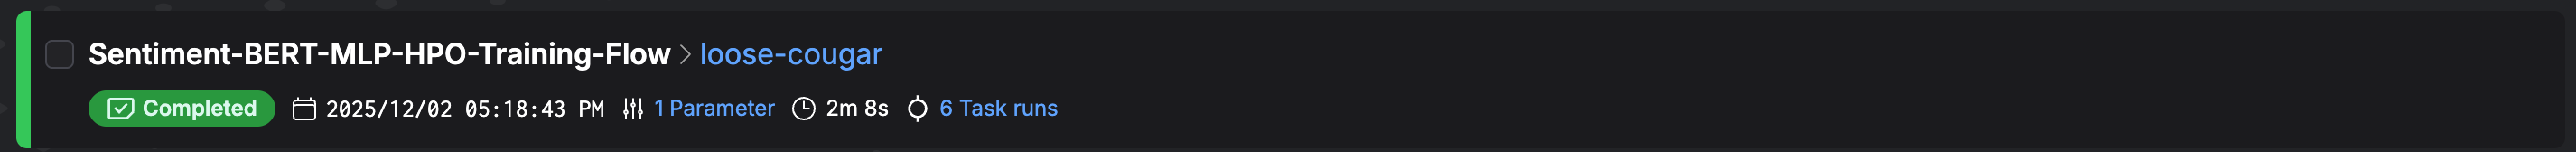

---

### 5.6 Servir el modelo (API con FastAPI)
#### 5.6.1 Objetivo del servicio

Proveer un servicio REST de inferencia de sentimiento para comentarios de texto, permitiendo:
- Predicción bajo demanda (petición por comentario).
- Selección de backend (`mlp_transformer`, `bert_nlptown`, `bert_distilbert`) para comparaciones.

#### 5.6.2 Endpoints

En `src/backend/api.py` se definen:

- GET `/health`

Devuelve {"status": "ok"} para verificar estado del servicio.

- POST `/api/v1/predict-sentiment`

Request (JSON):
```json{
"text": "I really enjoyed this post, the discussion was super insightful!",
"model_key": "mlp_transformer"
}
```

Response (JSON):
```json{
"label": "positive",
"score": 0.91,
"model_key": "mlp_transformer",
"backend_model_name": "workspace.default.EMI_imedia_sentiment_deep_model_NTBK@champion",
"warning": null
}
```

#### 5.6.3 Flujo interno

- Resolución de tracking URI y registry URI (Databricks UC).
- Carga perezosa (con @lru_cache) del modelo MLP champion desde
`models:/workspace.default.EMI_imedia_sentiment_deep_model_NTBK@champion`.
- Carga también del `SentenceTransformer all-MiniLM-L6-v2`.
- Carga perezosa de modelos BERT desde HuggingFace según model_key.
- Validación de la petición con pydantic (SentimentRequest).
- Enrutamiento de la predicción:
    - MLP: generación de embeddings, predict_proba y umbral 0.#### 5.
    - BERT: tokenización, forward pass, softmax y mapeo a etiqueta textual.
    - Devolución de la respuesta en el esquema SentimentResponse.

#### 5.6.4 Manejo de errores

En caso de model_key desconocida, la `API` usa el MLP por defecto y devuelve un warning en la respuesta.
Errores internos se reflejan con códigos `HTTP` 5xx estándar (gestión típica de `FastAPI/Uvicorn`).

---

#### 5.7 Interfaz gráfica (Streamlit)
#### 5.7.1 Objetivo

Ofrecer una `UI` sencilla para que usuarios técnicos y de negocio puedan probar el modelo sin necesidad de usar herramientas de línea de comandos o clientes `HTTP`.

#### 5.7.2 Componentes

En `src/frontend/main.py`:

- Selector de modelo en la barra lateral:
    - MLP + SentenceTransformer.
    - BERT multilingüe.
    - DistilBERT SST-2.
    - Campo de texto para escribir o pegar un comentario de Reddit.
    - Botón “Analizar sentimiento” que lanza una petición POST al endpoint del backend.

- Visualización de:
    - Etiqueta predicha con emoji.
    - Score de confianza (st.metric).
    - Mensajes de éxito/advertencia según umbral configurable en la UI.
    - JSON completo de la respuesta (para depuración).

#### 5.7.3 Ejecución local

`uv run streamlit run src/frontend/main.py`

La app se conecta al backend a través de la variable de entorno BACKEND_URL (por defecto apunta al Space de HuggingFace del backend), por lo que se recomienda primero correr la parte backend y luego la parte frontend.

---

#### 5.8 Contenerización del servicio (Docker)
#### 5.8.1 Dockerfile backend

- Ubicado en `src/backend/Dockerfile` Características:

    - Imagen base: `python:3.11-slim`.
    - Instalación de dependencias de sistema mínimas (build-essential, git, curl).
    - Variables de entorno para cache de HuggingFace (HF_HOME, TRANSFORMERS_CACHE).
    - Instalación de dependencias Python desde requirements.txt (FastAPI, Transformers, MLflow, SentenceTransformers, etc.).
    - Exposición del puerto 8000.
    - Comando de inicio:

        `uvicorn api:app --host 0.0.0.0 --port 8000`

#### 5.8.2 Dockerfile frontend

- Ubicado en `src/frontend/Dockerfile`:
    - Imagen base: `python:3.11-slim`.
    - Instalación de dependencias desde requirements.txt (principalmente Streamlit y requests).
    - Exposición del puerto 8501.
    - Comando de inicio:

        `streamlit run main.py --server.port=8501 --server.address=0.0.0.0`

#### 5.8.3 docker-compose.yaml

En la raíz del proyecto:
- Define servicios api y ui, cada uno con su context apuntando al subdirectorio correspondiente.
- Mapea los puertos:
    - api → 8000.
    - ui → 8501.

IMPORTANTE: REVISAR QUE EL context DE CADA SERVICIO APUNTE A src/backend Y src/frontend RESPECTIVAMENTE, PARA EVITAR ENVIAR LA RAÍZ COMPLETA DEL PROYECTO.

Ejemplo de ejecucion: 
    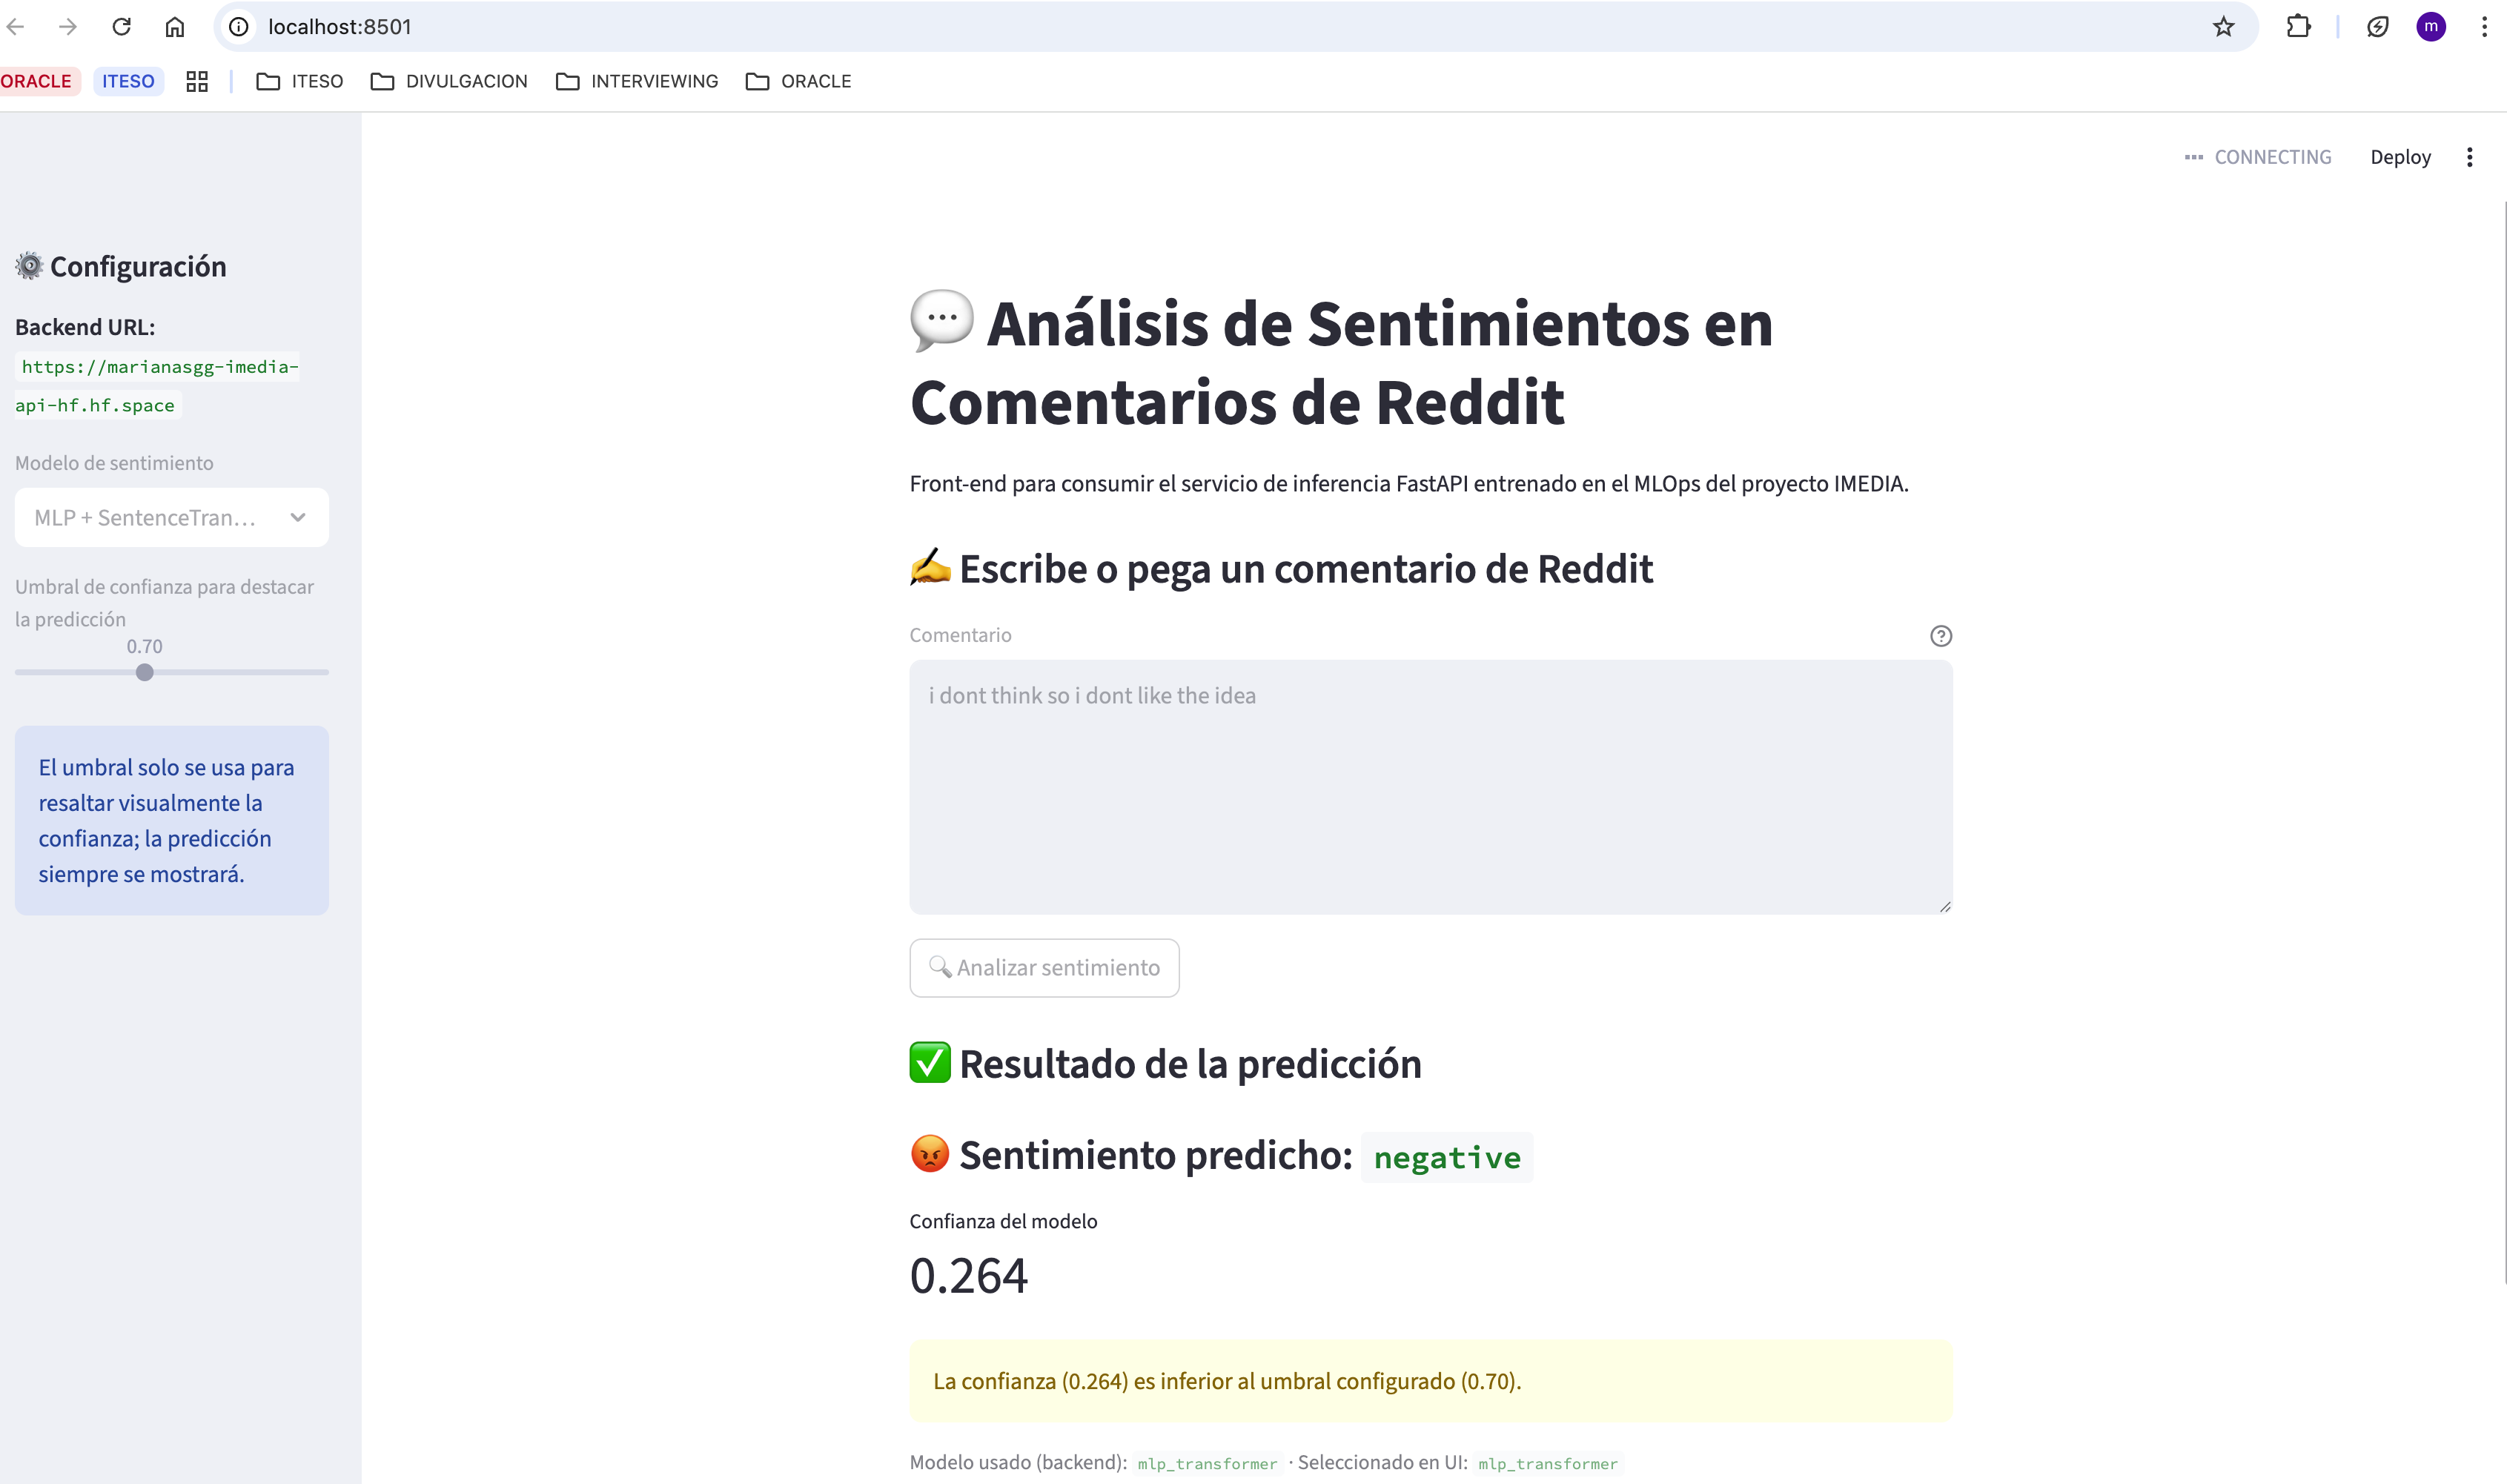

---

#### 5.9 Despliegue del servicio en la nube
#### 5.9.1 Plataforma

Se utiliza HuggingFace Spaces para desplegar el backend de FastAPI:
Imagen Docker personalizada del backend se construye y publica como Space (por ejemplo marianasgg-imedia-api-hf).
La UI de Streamlit puede ejecutarse localmente apuntando a este backend o también desplegarse como otro Space.

#### 5.9.2 Pasos generales

- Crear un nuevo Space en HuggingFace (tipo Docker).
- Subir Dockerfile y el código del backend (o enlazar el repositorio).
- Definir las variables de entorno necesarias (`DATABRICKS_HOST`, `DATABRICKS_TOKEN`, etc.).
- Esperar a que HuggingFace construya y arranque el contenedor.
- Probar GET `/health` y POST `/api/v1/predict-sentiment` desde la UI o herramientas como `curl/Postman`.

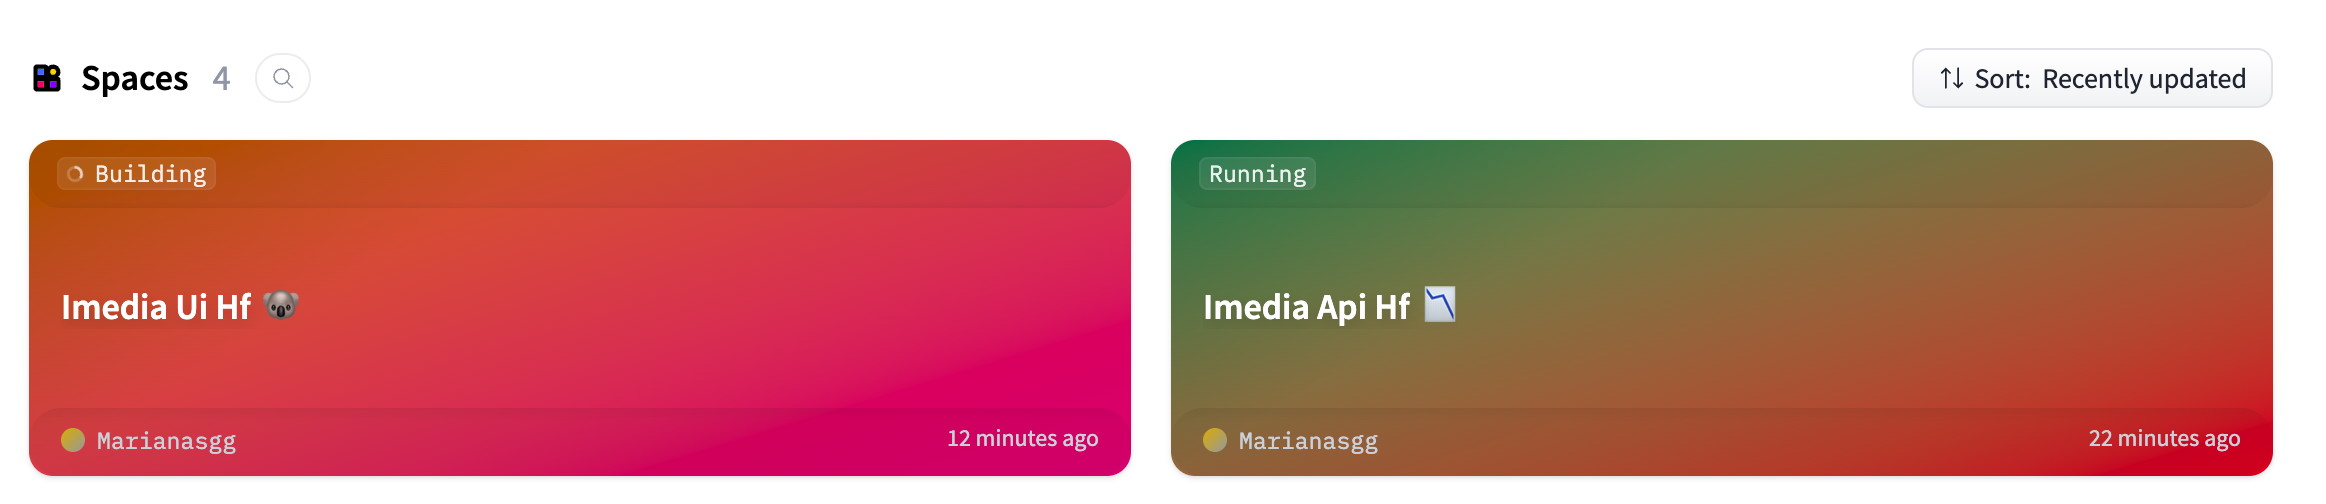


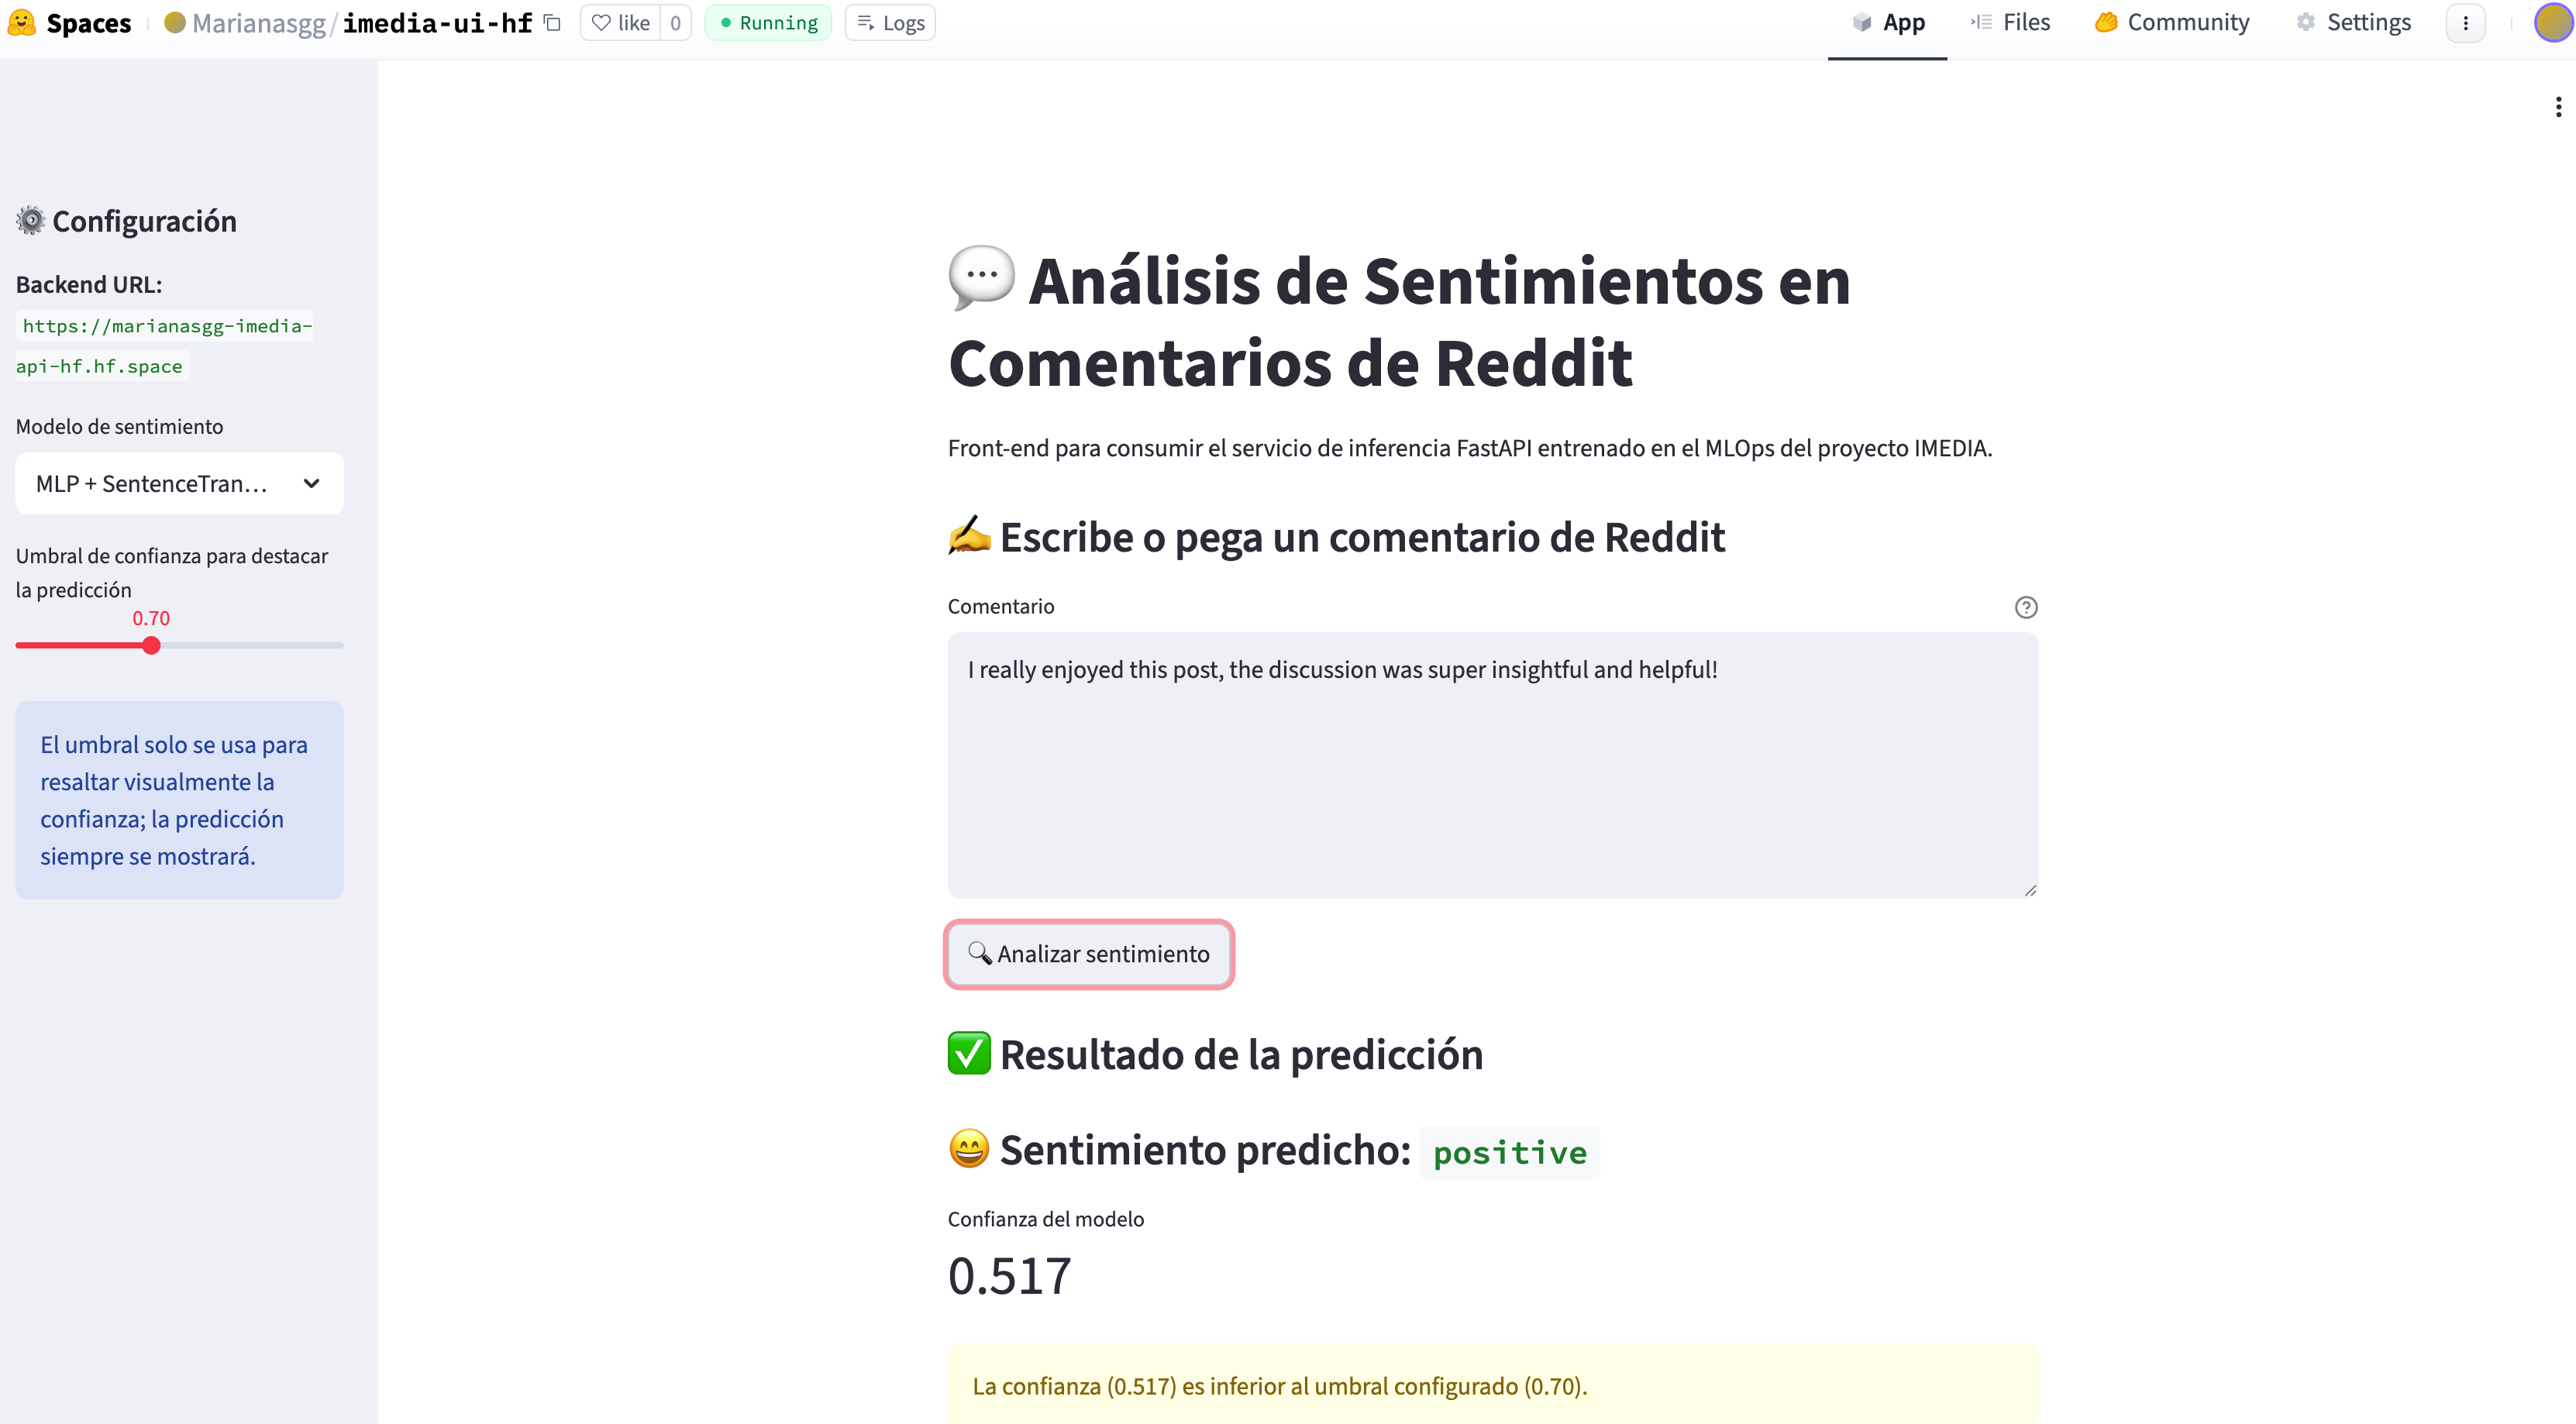

---

## 6. Conclusiones y recomendaciones

Se construyó un pipeline de extremo a extremo para análisis de sentimientos en comentarios de Reddit, desde el procesamiento de datos hasta el despliegue en la nube.

Tras comparar tres familias de modelos, el MLP sobre embeddings de SentenceTransformer resultó ser el mejor compromiso entre rendimiento y costo, alcanzando F1 ≈ 0.71 en test, por encima de los baselines BERT utilizados solo en inferencia.

La integración de Prefect + MLflow + Databricks UC permite:
- Repetir entrenamientos de forma controlada.
- Auditar qué datos, hiperparámetros y artefactos generaron cada modelo.
- Versionar y promover modelos mediante alias (champion).
- Limitaciones y líneas futuras:
    - Ampliar el dataset (más comentarios, más subreddits, diferenciación de idiomas).
    - Explorar fine-tuning ligero de un BERT compacto sobre este dataset, comparándolo con el MLP.
    - Incorporar features adicionales (metadatos, léxicos de emoción) en un modelo híbrido texto + metadata.
    - Desarrollar una estrategia de retraining periódico (por ejemplo, mensual) orquestada por Prefect.
    - Añadir monitoreo en producción (drift de datos, rendimiento real, logging de predicciones).

---

## 7. Referencias

- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. https://arxiv.org/abs/1810.04805

- Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. https://arxiv.org/abs/1908.10084

- Wolf, T., Chaumond, J., Debut, L., Sanh, V., & others. (2020). Transformers: State-of-the-Art Natural Language Processing. https://arxiv.org/abs/1910.03771

- Viñán-Ludeña, M. S., et al. (2022). Discovering a tourism destination with social media data using sentiment analysis. Emerald Publishing. https://doi.org/10.1108/JHTT-05-2021-0154

- MLflow Documentation – ML lifecycle platform. https://mlflow.org/docs/latest/index.html

- FastAPI Documentation – High performance API framework for Python. https://fastapi.tiangolo.com/

- Prefect Documentation – Orchestration for modern data workflows. https://docs.prefect.io/

- HuggingFace Documentation – Transformers & Sentence-Transformers. https://huggingface.co/docs

- Databricks Documentation – Machine Learning & Unity Catalog Model Registry. https://docs.databricks.com/
    